# 📘 **Post-Earnings Announcement Drift (PEAD) in the 21st Century: Evidence from US Equities**

In this project, I investigate whether **Post-Earnings Announcement Drift** (PEAD) persists in U.S. equity markets using data from 2000 to 2023. I use event study methodology, risk-adjusted returns, and hypothesis testing to evaluate the magnitude and statistical significance of the drift.

### **Primary Objectives**
1. Define and calculate **Earnings Surprises (SUE)**
2. Construct **event windows and estimation windows**
3. Calculate **abnormal returns**, **CAR**, and **SCAR**
4. Test significance and explore **economic explanations**

---

## ⚙️ **Step 1: Environment Setup and Data Import**

This section sets up Python libraries and imports all relevant datasets:
- Compustat Quarterly
- CRSP Daily Returns
- Linking Table (Compustat–CRSP)
- Fama-French 5-Factor Data
- CRSP Market Return File
- IBES Consensus Analyst Earnings Forecasts

In [1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS

import statsmodels.formula.api as smf
from pandas.tseries.offsets import DateOffset
from scipy import stats

In [2]:
# --- Import CSVs Directly ---
compustat_df = pd.read_csv("Compustat_Q.csv")
crsp_df = pd.read_csv("CRSP.csv")
linking_df = pd.read_csv("Linking Table.csv")
ff5_df = pd.read_csv("FF5.csv")
market_df = pd.read_csv("Market Returns (CRSP).csv")
ibes_df = pd.read_csv("IBES_data.csv")

# --- Quick Shape Check ---
print("Compustat_df:", compustat_df.shape)
print("CRSP_df:", crsp_df.shape)
print("Linking_df:", linking_df.shape)
print("FF5_df:", ff5_df.shape)
print("Market_df:", market_df.shape)
print("IBES_df:", ibes_df.shape)

C:\Users\Asus\AppData\Local\Temp\ipykernel_15464\3888683970.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp_df = pd.read_csv("CRSP.csv")


Compustat_df: (5000, 22)
CRSP_df: (316649, 12)
Linking_df: (72, 10)
FF5_df: (6037, 8)
Market_df: (6037, 5)
IBES_df: (14350, 12)


## 🧹 **Step 2: Data Cleaning and Linking**

- Parse date columns and standardize formats
- Filter relevant columns
- Link `gvkey` from Compustat to `PERMNO` in CRSP using the linking table
- Prepare merged dataset with earnings announcement dates and return data
- merging and preparing IBES data

In [3]:
# =================================================================================
# Data Cleaning and Linking (using standard WRDS column names)
# =================================================================================

# Part 1: Clean Compustat data

# Convert standard WRDS date columns to datetime format
# Using 'datadate' for the fiscal period end and 'rdq' for the announcement date
compustat_df['datadate'] = pd.to_datetime(compustat_df['datadate'], errors='coerce')
compustat_df['rdq'] = pd.to_datetime(compustat_df['rdq'], errors='coerce')

# Drop rows with missing standard EPS ('epspxq') or announcement date ('rdq') variables
compustat_df = compustat_df.dropna(subset=['epspxq', 'rdq'])

# Sort each firm’s data by fiscal year and quarter for correct lag operations
compustat_df = compustat_df.sort_values(by=['gvkey', 'fyearq', 'fqtr']).reset_index(drop=True)

print("Compustat cleaned. Rows remaining:", len(compustat_df))


# Part 2: Link Compustat data to CRSP identifiers

# Keep only primary links (P) with link types LC or LU
linking_clean = linking_df[
    (linking_df['LINKPRIM'] == 'P') &
    (linking_df['LINKTYPE'].isin(['LC', 'LU']))
].copy()

# Convert linking dates to datetime format
linking_clean['LINKENDDT'] = pd.to_datetime(linking_clean['LINKENDDT'], errors='coerce')
linking_clean['LINKDT'] = pd.to_datetime(linking_clean['LINKDT'], errors='coerce')

# Replace missing end dates with a future date to ensure links are kept
linking_clean['LINKENDDT'] = linking_clean['LINKENDDT'].fillna(pd.to_datetime('2025-12-31'))


# Merge Compustat and linking table on gvkey
compustat_linked = pd.merge(
    compustat_df,
    linking_clean[['gvkey', 'LPERMNO', 'LINKDT', 'LINKENDDT']],
    on='gvkey',
    how='left'
)

# Keep rows where 'rdq' (the announcement date) falls within the valid link range
compustat_linked = compustat_linked[
    (compustat_linked['rdq'] >= compustat_linked['LINKDT']) &
    (compustat_linked['rdq'] <= compustat_linked['LINKENDDT'])
].copy()

# Rename LPERMNO to permno to match CRSP format
compustat_linked = compustat_linked.rename(columns={'LPERMNO': 'permno'})

print("Linking complete. Rows with valid permno and earnings dates:", len(compustat_linked))


# =================================================================================
# Merging and Preparing IBES Data
# =================================================================================

# --- Step 1: Clean the IBES Data ---
# This part is correct and uses your specific file names.
ibes_df['ANNDATS_ACT'] = pd.to_datetime(ibes_df['ANNDATS_ACT'], errors='coerce')
ibes_df['FPEDATS'] = pd.to_datetime(ibes_df['FPEDATS'], errors='coerce')
ibes_df['STATPERS'] = pd.to_datetime(ibes_df['STATPERS'], errors='coerce')
ibes_df = ibes_df[ibes_df['MEASURE'] == 'EPS'].copy()
ibes_df = ibes_df.dropna(subset=['ANNDATS_ACT', 'FPEDATS', 'MEANEST', 'ACTUAL', 'CUSIP'])
ibes_df = ibes_df.rename(columns={'TICKER': 'tic'})

print("IBES data loaded and cleaned.")


# --- Step 2: Merge Compustat-CRSP data with IBES data using Ticker ---

# Using 'datadate' from compustat_linked to match the fiscal period end date.
merged_ibes_df = pd.merge(
    compustat_linked,
    ibes_df,
    left_on=['tic', 'datadate'], 
    right_on=['tic', 'FPEDATS'],  
    how='inner'
)

print(f"Initial merge on Ticker and Date created {len(merged_ibes_df)} potential forecast matches.")


# --- Step 3: Isolate the MOST RECENT forecast for each announcement ---

# Using 'rdq' as the announcement date from compustat_linked.
# Filter out any forecasts that were compiled on or after the announcement date.
merged_ibes_df = merged_ibes_df[merged_ibes_df['STATPERS'] < merged_ibes_df['rdq']].copy()

# For each event, sort the forecasts by date to find the most recent one
merged_ibes_df = merged_ibes_df.sort_values(by='STATPERS', ascending=False)

# Using 'rdq' to identify unique events.
# Drop duplicate events, keeping only the first occurrence (which is now the latest forecast)
final_event_df = merged_ibes_df.drop_duplicates(subset=['permno', 'rdq'], keep='first')

print(f"Final dataset with unique pre-announcement forecasts contains {len(final_event_df)} events.")
display(final_event_df[['permno', 'rdq', 'tic', 'STATPERS', 'MEANEST', 'ACTUAL']].head())

Compustat cleaned. Rows remaining: 4990
Linking complete. Rows with valid permno and earnings dates: 4889
IBES data loaded and cleaned.
Initial merge on Ticker and Date created 9288 potential forecast matches.
Final dataset with unique pre-announcement forecasts contains 3106 events.


C:\Users\Asus\AppData\Local\Temp\ipykernel_15464\2639635849.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  linking_clean['LINKENDDT'] = pd.to_datetime(linking_clean['LINKENDDT'], errors='coerce')


,permno,rdq,tic,STATPERS,MEANEST,ACTUAL
8691,77702.0,2024-01-30,SBUX,2023-12-14,0.96,0.90
298,20482.0,2024-01-24,ABT,2023-12-14,1.19,1.19
2419,26403.0,2024-02-07,DIS,2023-12-14,1.05,1.22
6900,15579.0,2024-01-23,TXN,2023-12-14,1.46,1.49
2716,27959.0,2024-02-08,DUK,2023-12-14,1.55,1.51


## 📏 **Step 3: Compute Standardized Unexpected Earnings (SUE)**

I implement two SUE measures:
1. **EPS-based**: using past 8 quarters of reported EPS.
2. **IBES-based**: using analyst forecasts.

I also define terciles (positive, neutral, negative) based on SUE.

In [4]:
# ========================================================================
# Compute EPS-Based Standardized Unexpected Earnings (SUE)
# ========================================================================

# Sort data to ensure correct calculations within each firm group

compustat_linked = compustat_linked.sort_values(by=['permno', 'rdq']).reset_index(drop=True)

# Calculate lagged EPS (EPS from 4 quarters ago)

compustat_linked['epspxq_lag4'] = compustat_linked.groupby('permno')['epspxq'].shift(4)

# Calculate the earnings change (the surprise component)

compustat_linked['earnings_change'] = compustat_linked['epspxq'] - compustat_linked['epspxq_lag4']

# Calculate the rolling standard deviation of the *earnings change* over the prior 8 quarters
# This is a more robust standardizer than the standard deviation of EPS levels
compustat_linked['earnings_change_sd'] = compustat_linked.groupby('permno')['earnings_change'].rolling(window=8, min_periods=4).std().reset_index(0,drop=True)

# Calculate the new, robust SUE
compustat_linked['sue_eps'] = compustat_linked['earnings_change'] / compustat_linked['earnings_change_sd']

# Winsorize the SUE at the 1st and 99th percentiles
sue_lower = compustat_linked['sue_eps'].quantile(0.01)
sue_upper = compustat_linked['sue_eps'].quantile(0.99)
compustat_linked['sue_eps_wins'] = compustat_linked['sue_eps'].clip(lower=sue_lower, upper=sue_upper)

# Define SUE groups (terciles)
sue_q30 = compustat_linked['sue_eps_wins'].quantile(0.30)
sue_q70 = compustat_linked['sue_eps_wins'].quantile(0.70)

def classify_sue_group(sue):
    if pd.isna(sue):
        return 'Neutral' # Assign NaNs to Neutral or drop later
    if sue <= sue_q30:
        return 'Negative Surprise'
    elif sue >= sue_q70:
        return 'Positive Surprise'
    else:
        return 'Neutral'

compustat_linked['sue_group'] = compustat_linked['sue_eps_wins'].apply(classify_sue_group)

print("SUE calculation and grouping complete.")
print(compustat_linked['sue_group'].value_counts())

SUE calculation and grouping complete.
sue_group
Neutral              2161
Negative Surprise    1364
Positive Surprise    1364
Name: count, dtype: int64


### **Section 3.1 SUE Based on IBES Forecasts**
---

In [5]:
# =================================================================================
# Calculate Standardized Unexpected Earnings (SUE) using IBES Data
# =================================================================================

# This code assumes 'final_event_df' has been created from the previous step.
# We add 'event_id' here for future merging.
if 'event_id' not in final_event_df.columns:
    final_event_df = final_event_df.reset_index().rename(columns={'index': 'event_id'})


# --- Step 1: Calculate the Earnings Surprise (Numerator) ---
final_event_df['surprise_ibes'] = final_event_df['ACTUAL'] - final_event_df['MEANEST']

# Step 1.5: Impose a Minimum Standard Deviation Floor
# This avoids division by near-zero STDEVs that inflate SUEs
min_stdev_floor = 0.05  # Common value in PEAD literature (some papers use 0.03 to 0.05)
final_event_df['stdev_adj'] = final_event_df['STDEV'].apply(lambda x: max(x, min_stdev_floor))


# Step 2: Standardize the Surprise using the adjusted STDEV
final_event_df['sue_ibes'] = final_event_df['surprise_ibes'] / final_event_df['stdev_adj']



# --- Step 3: Winsorize and Group the IBES-based SUE ---
sue_ibes_lower = final_event_df['sue_ibes'].quantile(0.01)
sue_ibes_upper = final_event_df['sue_ibes'].quantile(0.99)
final_event_df['sue_ibes_wins'] = final_event_df['sue_ibes'].clip(lower=sue_ibes_lower, upper=sue_ibes_upper)

sue_ibes_q30 = final_event_df['sue_ibes_wins'].quantile(0.30)
sue_ibes_q70 = final_event_df['sue_ibes_wins'].quantile(0.70)

def classify_sue_group_ibes(sue):
    if pd.isna(sue):
        return 'Neutral_IBES'
    if sue <= sue_ibes_q30:
        return 'Negative Surprise_IBES'
    elif sue >= sue_ibes_q70:
        return 'Positive Surprise_IBES'
    else:
        return 'Neutral_IBES'

final_event_df['sue_group_ibes'] = final_event_df['sue_ibes_wins'].apply(classify_sue_group_ibes)

print("\nIBES-based SUE calculation and grouping complete.")
print("Distribution of new SUE groups:")
print(final_event_df['sue_group_ibes'].value_counts())
display(final_event_df[['event_id', 'permno', 'rdq', 'sue_ibes_wins', 'sue_group_ibes']].head())


IBES-based SUE calculation and grouping complete.
Distribution of new SUE groups:
sue_group_ibes
Neutral_IBES              1184
Positive Surprise_IBES     990
Negative Surprise_IBES     932
Name: count, dtype: int64


,event_id,permno,rdq,sue_ibes_wins,sue_group_ibes
0,8691,77702.0,2024-01-30,-1.200,Negative Surprise_IBES
1,298,20482.0,2024-01-24,0.000,Negative Surprise_IBES
2,2419,26403.0,2024-02-07,2.125,Positive Surprise_IBES
3,6900,15579.0,2024-01-23,0.600,Neutral_IBES
4,2716,27959.0,2024-02-08,-0.800,Negative Surprise_IBES


## ⏳ **Section 4: Data Preparation for the Event Study**

I use three models to calculate Abnormal Returns:
- Market Adjusted Model
- CAPM
- Fama-French 5-Factor Model

Returns are estimated over the estimation window and used to compute abnormal returns.

### **Global Data Preparation**

In [6]:
# =================================================================
# Data Preparation for Event Study
# =================================================================

# --- Part 1: Finalize the Event List DataFrame ---
# This ensures the compustat_linked DataFrame is clean and ready.
# We will add a unique ID to each event for easier processing later.

valid_events_df = compustat_linked.dropna(
    subset=['permno', 'rdq', 'sue_eps_wins']
).copy()
valid_events_df['permno'] = valid_events_df['permno'].astype(int)
valid_events_df = valid_events_df.sort_values(by=['permno', 'rdq']).reset_index(drop=True)
valid_events_df['event_id'] = valid_events_df.index # Assign a unique ID to each event

print("Step 4, Part 1: Event list finalized.")
print(f"Found {len(valid_events_df)} valid earnings announcement events.")


# --- Part 2: Prepare a Master Daily Stock & Factor DataFrame ---
# Here, we merge CRSP returns with the Fama-French factors. This single
# master DataFrame will be used for all subsequent calculations.

# Convert date columns to datetime objects
crsp_df['date'] = pd.to_datetime(crsp_df['date'])
ff5_df['date'] = pd.to_datetime(ff5_df['date'])

# Prepare CRSP data: handle missing values and rename columns
crsp_df['RET'] = pd.to_numeric(crsp_df['RET'], errors='coerce')
crsp_df = crsp_df.dropna(subset=['RET'])
crsp_df = crsp_df.rename(columns={'PERMNO': 'permno'})

# Merge CRSP daily returns with Fama-French 5 factors
crsp_ff_df = pd.merge(crsp_df[['permno', 'date', 'RET']], ff5_df, on='date', how='left')

# Calculate the firm's daily excess return (Firm Return - Risk-Free Rate)
crsp_ff_df['excess_ret'] = crsp_ff_df['RET'] - crsp_ff_df['rf']

# Drop any rows that couldn't be merged with FF data to ensure data integrity
crsp_ff_df = crsp_ff_df.dropna().sort_values(by=['permno', 'date'])

print("\nStep 4, Part 2: Master CRSP and Fama-French data prepared.")
print("Sample of prepared daily data:")
display(crsp_ff_df.head())

Step 4, Part 1: Event list finalized.
Found 4546 valid earnings announcement events.

Step 4, Part 2: Master CRSP and Fama-French data prepared.
Sample of prepared daily data:


,permno,date,RET,mktrf,smb,hml,rmw,cma,rf,umd,excess_ret
0,10104,2000-01-03,0.054099,-0.0071,-0.0009,-0.0132,-0.0148,-0.0071,0.00021,-0.0006,0.053889
1,10104,2000-01-04,-0.088360,-0.0406,0.0034,0.0207,0.0053,0.0136,0.00021,-0.0191,-0.088570
2,10104,2000-01-05,-0.052815,-0.0009,0.0036,-0.0005,0.0045,0.0115,0.00021,-0.0049,-0.053025
3,10104,2000-01-06,-0.058824,-0.0074,-0.0004,0.0124,0.0064,0.0121,0.00021,-0.0149,-0.059034
4,10104,2000-01-07,0.076823,0.0321,-0.0089,-0.0157,-0.0083,-0.0100,0.00021,0.0059,0.076613


### **Section 4.1: Unified Event Study Loop for All Three Models**
---

In [7]:
# ============================================================================================
# FINAL UNIFIED EVENT STUDY LOOP: Market-Adjusted, CAPM, Fama-French 5-Factor
# ============================================================================================

# Initialize lists
summary_results_list = []
daily_ar_list = []

# Define window sizes
estimation_window_size = 120
pre_event_window = 10
event_window_start_day = -20
event_window_end_day = 90
drift_windows = {'CAR[2,30]': (2, 30), 'CAR[2,60]': (2, 60), 'CAR[2,90]': (2, 90)}

for index, event in valid_events_df.iterrows():
    permno = event['permno']
    event_date = event['rdq']
    sue_group = event['sue_group']
    event_id = event['event_id']

    firm_returns = crsp_ff_df[crsp_ff_df['permno'] == permno].set_index('date')
    if firm_returns.shape[0] < 252:
        continue

    try:
        t0_index_loc = firm_returns.index.searchsorted(event_date)

        estimation_start_idx = t0_index_loc - estimation_window_size - pre_event_window
        estimation_end_idx = t0_index_loc - pre_event_window
        event_start_idx = t0_index_loc + event_window_start_day
        event_end_idx = t0_index_loc + event_window_end_day + 1

        if estimation_start_idx < 0 or event_end_idx > firm_returns.shape[0]:
            continue
    except Exception:
        continue

    estimation_data = firm_returns.iloc[estimation_start_idx:estimation_end_idx]
    event_data = firm_returns.iloc[event_start_idx:event_end_idx].copy()

    if estimation_data.shape[0] < 30:
        continue

    # --- Model 1: Market-Adjusted AR ---
    event_data['ar_mkt'] = event_data['excess_ret'] - event_data['mktrf']

    # --- Model 2: CAPM AR ---
    try:
        X_capm = sm.add_constant(estimation_data[['mktrf']])
        Y_capm = estimation_data['excess_ret']
        capm_model = sm.OLS(Y_capm, X_capm, missing='drop').fit()
        X_event_capm = sm.add_constant(event_data[['mktrf']], has_constant='add')
        event_data['ar_capm'] = event_data['excess_ret'] - capm_model.predict(X_event_capm)
        std_resid_capm = capm_model.resid.std()
    except:
        event_data['ar_capm'] = np.nan
        std_resid_capm = np.nan

    # --- Model 3: FF5 AR ---
    try:
        X_ff5 = sm.add_constant(estimation_data[['mktrf', 'smb', 'hml', 'rmw', 'cma']])
        Y_ff5 = estimation_data['excess_ret']
        ff5_model = sm.OLS(Y_ff5, X_ff5, missing='drop').fit()
        X_event_ff5 = sm.add_constant(event_data[['mktrf', 'smb', 'hml', 'rmw', 'cma']], has_constant='add')
        event_data['ar_ff5'] = event_data['excess_ret'] - ff5_model.predict(X_event_ff5)
        std_resid_ff5 = ff5_model.resid.std()
    except:
        event_data['ar_ff5'] = np.nan
        std_resid_ff5 = np.nan

    # --- Finalize Event Metadata ---
    event_data['event_id'] = event_id
    event_data['event_day'] = range(event_window_start_day, event_window_start_day + len(event_data))
    daily_ar_list.append(event_data[['event_id', 'event_day', 'ar_mkt', 'ar_capm', 'ar_ff5']])

    # --- Calculate CARs and SCARs for All Models ---
    summary_event_results = {
        'event_id': event_id,
        'permno': permno,
        'event_date': event_date,
        'sue_eps_wins': event['sue_eps_wins'],
        'sue_group': sue_group
    }

    for label, (start, end) in drift_windows.items():
        # --- Market Model ---
        window_ar = event_data.query(f"{start} <= event_day <= {end}")['ar_mkt']
        summary_event_results[label + '_CAR_MKT'] = window_ar.sum()

        # --- CAPM ---
        window_ar_capm = event_data.query(f"{start} <= event_day <= {end}")['ar_capm']
        car_capm = window_ar_capm.sum()
        n_days_capm = len(window_ar_capm)
        scar_capm = car_capm / (std_resid_capm * np.sqrt(n_days_capm)) if std_resid_capm and n_days_capm > 0 else np.nan
        summary_event_results[label + '_CAR_CAPM'] = car_capm
        summary_event_results[label + '_SCAR_CAPM'] = scar_capm

        # --- FF5 ---
        window_ar_ff5 = event_data.query(f"{start} <= event_day <= {end}")['ar_ff5']
        car_ff5 = window_ar_ff5.sum()
        n_days_ff5 = len(window_ar_ff5)
        scar_ff5 = car_ff5 / (std_resid_ff5 * np.sqrt(n_days_ff5)) if std_resid_ff5 and n_days_ff5 > 0 else np.nan
        summary_event_results[label + '_CAR_FF5'] = car_ff5
        summary_event_results[label + '_SCAR_FF5'] = scar_ff5

    summary_results_list.append(summary_event_results)

# --- Finalize Outputs ---
final_results_df = pd.DataFrame(summary_results_list)
final_daily_ar_df = pd.concat(daily_ar_list, ignore_index=True)
final_daily_ar_df = pd.merge(final_daily_ar_df, valid_events_df[['event_id', 'sue_group']], on='event_id')

print("\nUnified Event Study Complete!")
print(f"Final event summary shape: {final_results_df.shape}")
print(f"Final daily AR shape: {final_daily_ar_df.shape}")



Unified Event Study Complete!
Final event summary shape: (4454, 20)
Final daily AR shape: (494394, 6)


## 📉 **Step 5: Visualize AAR, CAAR, and Group Comparisons**

I create:
- Time-series plots of CAAR for each group
- Bar charts of CAR/SCAR by tercile
- Scatterplots of SUE vs CAR

### **Market Adjusted Model - CAAR Graph**
---

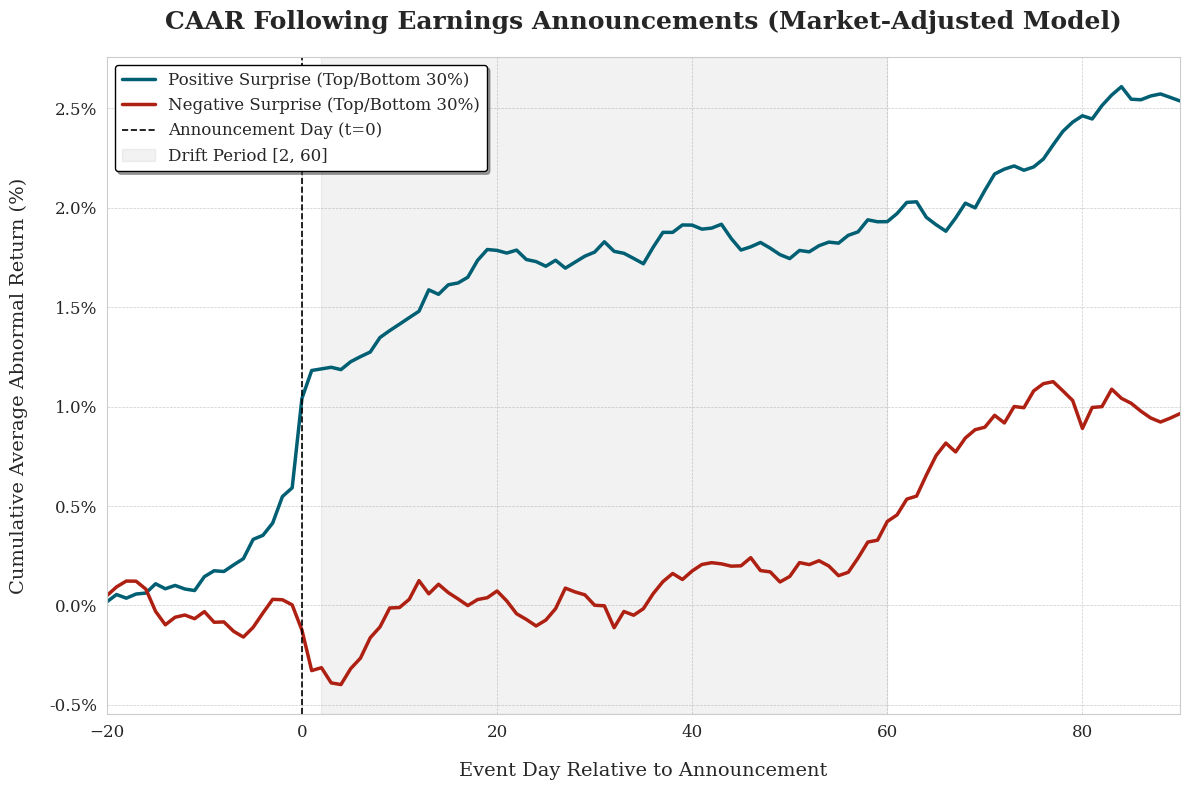

In [8]:
# =================================================================================
# CAAR PLOT: Market-Adjusted Model (Using Unified Loop Output)
# =================================================================================

# Step 1: Calculate AAR (Average Abnormal Return) and CAAR for each SUE group
aar_df_mkt = final_daily_ar_df.groupby(['sue_group', 'event_day'])['ar_mkt'].mean().reset_index()
aar_df_mkt['caar'] = aar_df_mkt.groupby('sue_group')['ar_mkt'].cumsum()

# Step 2: Pivot the CAAR data for easier plotting
caar_pivot_mkt = aar_df_mkt.pivot(index='event_day', columns='sue_group', values='caar')

# Step 3: Plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(12, 8))

# Optional: Customize colors for each SUE group
colors = {
    'Positive Surprise': '#005f73',
    'Negative Surprise': '#ae2012',
    'Neutral': '#9b9b9b'
}

# Step 4: Plot CAAR for Positive and Negative Surprise Groups
for group in ['Positive Surprise', 'Negative Surprise']:
    if group in caar_pivot_mkt.columns:
        ax.plot(
            caar_pivot_mkt.index,
            caar_pivot_mkt[group],
            label=f'{group} (Top/Bottom 30%)',
            color=colors.get(group, 'black'),
            linewidth=2.5
        )

# Step 5: Formatting and Annotations
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2, label='Announcement Day (t=0)')
ax.axvspan(2, 60, color='grey', alpha=0.1, label='Drift Period [2, 60]')
ax.set_title('CAAR Following Earnings Announcements (Market-Adjusted Model)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=14, labelpad=15)
ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=14, labelpad=15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax.set_xlim(-20, 90)

# Step 6: Legend and Grid
legend = ax.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_edgecolor('black')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### **Market Adjusted Model CAAR Graph - IBES Method**
---

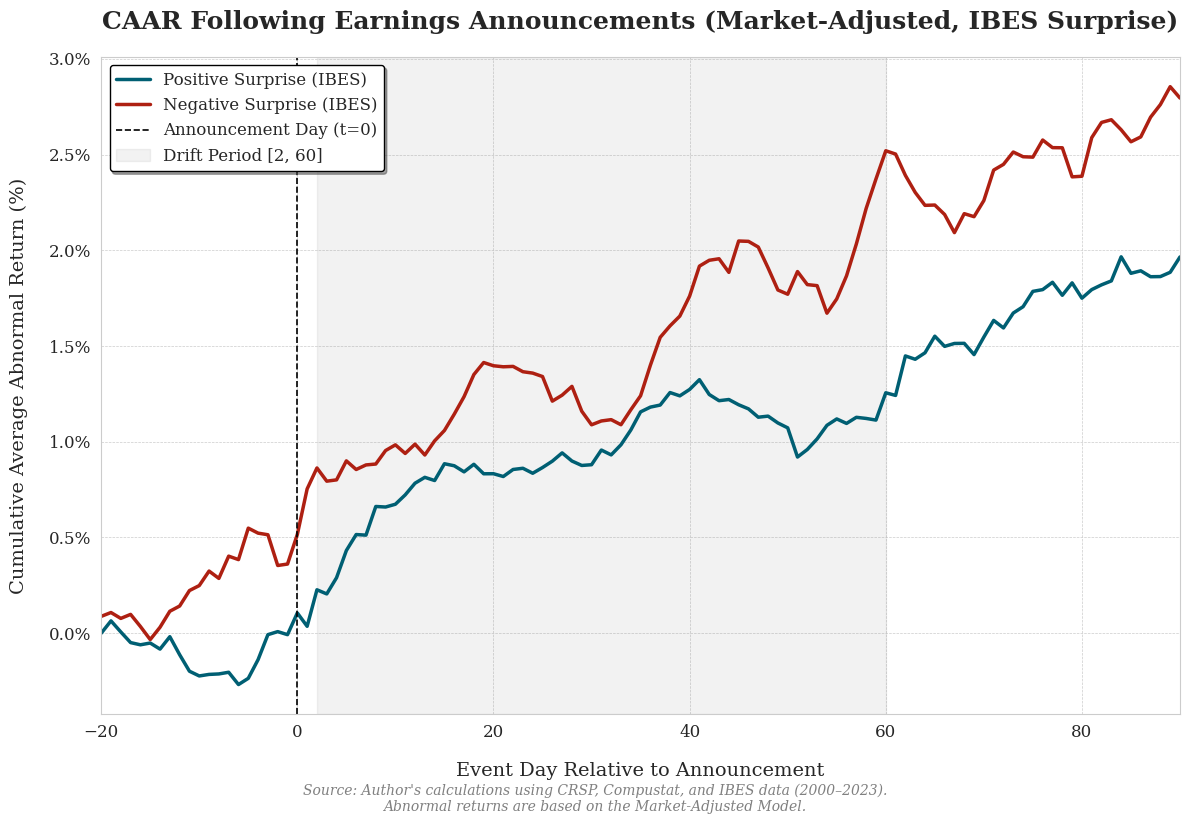

In [9]:
# =================================================================================
# VISUALIZATION: CAAR PLOT USING THE MARKET-ADJUSTED MODEL (IBES-based Surprise)
# =================================================================================

# --- Step 1: Link Daily Market-Adjusted AR data with the IBES SUE Groups ---

# Merge the 'sue_group_ibes' from IBES events onto the unified daily AR dataframe
ibes_groups_df = final_event_df[['event_id', 'sue_group_ibes']]

# Merge with the final daily AR dataframe (from the unified loop)
daily_ar_mkt_ibes_merged = pd.merge(final_daily_ar_df, ibes_groups_df, on='event_id')

# --- Step 2: Calculate AAR and CAAR grouped by IBES-based SUE groups ---

aar_df_mkt_ibes = daily_ar_mkt_ibes_merged.groupby(['sue_group_ibes', 'event_day'])['ar_mkt'].mean().reset_index()
aar_df_mkt_ibes['caar'] = aar_df_mkt_ibes.groupby('sue_group_ibes')['ar_mkt'].cumsum()

# Pivot for plotting
caar_pivot_mkt_ibes = aar_df_mkt_ibes.pivot(index='event_day', columns='sue_group_ibes', values='caar')

# --- Step 3: Generate the Publication-Quality Plot ---

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(12, 8))

# Define color and label mapping for IBES groups
colors = {
    'Positive Surprise_IBES': '#005f73',
    'Negative Surprise_IBES': '#ae2012'
}
labels = {
    'Positive Surprise_IBES': 'Positive Surprise (IBES)',
    'Negative Surprise_IBES': 'Negative Surprise (IBES)'
}

# Plot CAAR lines for Positive and Negative IBES groups
for group in ['Positive Surprise_IBES', 'Negative Surprise_IBES']:
    if group in caar_pivot_mkt_ibes.columns:
        ax.plot(
            caar_pivot_mkt_ibes.index,
            caar_pivot_mkt_ibes[group],
            label=labels[group],
            color=colors.get(group, 'black'),
            linewidth=2.5
        )

# --- Step 4: Annotations and Formatting ---

ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2, label='Announcement Day (t=0)')
ax.axvspan(2, 60, color='grey', alpha=0.1, label='Drift Period [2, 60]')

ax.set_title('CAAR Following Earnings Announcements (Market-Adjusted, IBES Surprise)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=14, labelpad=15)
ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=14, labelpad=15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax.set_xlim(-20, 90)

legend = ax.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_edgecolor('black')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.figtext(
    0.5, -0.02,
    "Source: Author's calculations using CRSP, Compustat, and IBES data (2000–2023).\nAbnormal returns are based on the Market-Adjusted Model.",
    ha='center', fontsize=10, style='italic', color='grey'
)

plt.tight_layout()
plt.show()


### **Diagonstic Checks**

In [10]:
# =================================================================================
# DIAGNOSTIC CHECKS: Validating IBES-based SUE Calculation and Group Assignment
# =================================================================================

print("\n========== DIAGNOSTIC CHECKS: IBES SUE Calculation ==========\n")

# --- Check 1: Distribution Summary of Raw SUE_IBES Values ---
print("\n[Check 1] Summary statistics of IBES-based SUEs (pre-winsorization):")
print(final_event_df['sue_ibes'].describe())

# --- Check 2: Count of Events per SUE Group (Post-Classification) ---
print("\n[Check 2] Number of events in each IBES SUE group (after winsorization and grouping):")
print(final_event_df['sue_group_ibes'].value_counts())

# --- Check 3: Directional Consistency: Bottom and Top 10 SUE_IBES Events ---
print("\n[Check 3] Bottom 10 and Top 10 SUE_IBES values with assigned group labels:")
print("\nLowest 10 SUE_IBES values (expected: all Negative Surprise_IBES):")
print(final_event_df[['sue_ibes', 'sue_group_ibes']].sort_values('sue_ibes').head(10))

print("\nHighest 10 SUE_IBES values (expected: all Positive Surprise_IBES):")
print(final_event_df[['sue_ibes', 'sue_group_ibes']].sort_values('sue_ibes').tail(10))

# --- Check 4: Sample-Level Consistency: Does ACTUAL > MEANEST correspond to Positive Surprise? ---
print("\n[Check 4] Random sample of 10 events: Confirm ACTUAL > MEANEST corresponds to Positive Surprise_IBES:")
print(final_event_df[['permno', 'rdq', 'ACTUAL', 'MEANEST', 'surprise_ibes', 'sue_ibes', 'sue_group_ibes']].sample(10))

# --- Check 5: Groupwise Surprise Mean Check ---
print("\n[Check 5] Mean actual earnings surprise (ACTUAL - MEANEST) by SUE Group:")
print(final_event_df.groupby('sue_group_ibes')['surprise_ibes'].describe())

# --- Check 6: Post-Merge Event ID Integrity Check (Optional but Recommended) ---
print("\n[Check 6] Verifying event ID mapping integrity for daily AR dataframe merge (row counts by SUE group):")
daily_ar_check = final_daily_ar_df.merge(final_event_df[['event_id', 'sue_group_ibes']], on='event_id', how='left')
print(daily_ar_check['sue_group_ibes'].value_counts())



========== DIAGNOSTIC CHECKS: IBES SUE Calculation ==========


[Check 1] Summary statistics of IBES-based SUEs (pre-winsorization):
count    3106.000000
mean        0.684587
std         1.660406
min       -24.363636
25%         0.000000
50%         0.400000
75%         1.142857
max        14.833333
Name: sue_ibes, dtype: float64

[Check 2] Number of events in each IBES SUE group (after winsorization and grouping):
sue_group_ibes
Neutral_IBES              1184
Positive Surprise_IBES     990
Negative Surprise_IBES     932
Name: count, dtype: int64

[Check 3] Bottom 10 and Top 10 SUE_IBES values with assigned group labels:

Lowest 10 SUE_IBES values (expected: all Negative Surprise_IBES):
       sue_ibes          sue_group_ibes
937  -24.363636  Negative Surprise_IBES
157  -18.939394  Negative Surprise_IBES
564  -18.142857  Negative Surprise_IBES
1154 -12.600000  Negative Surprise_IBES
260  -11.121212  Negative Surprise_IBES
1059 -10.400000  Negative Surprise_IBES
190   -8.200000  Negati

### **CAPM CAAR Plot**
---

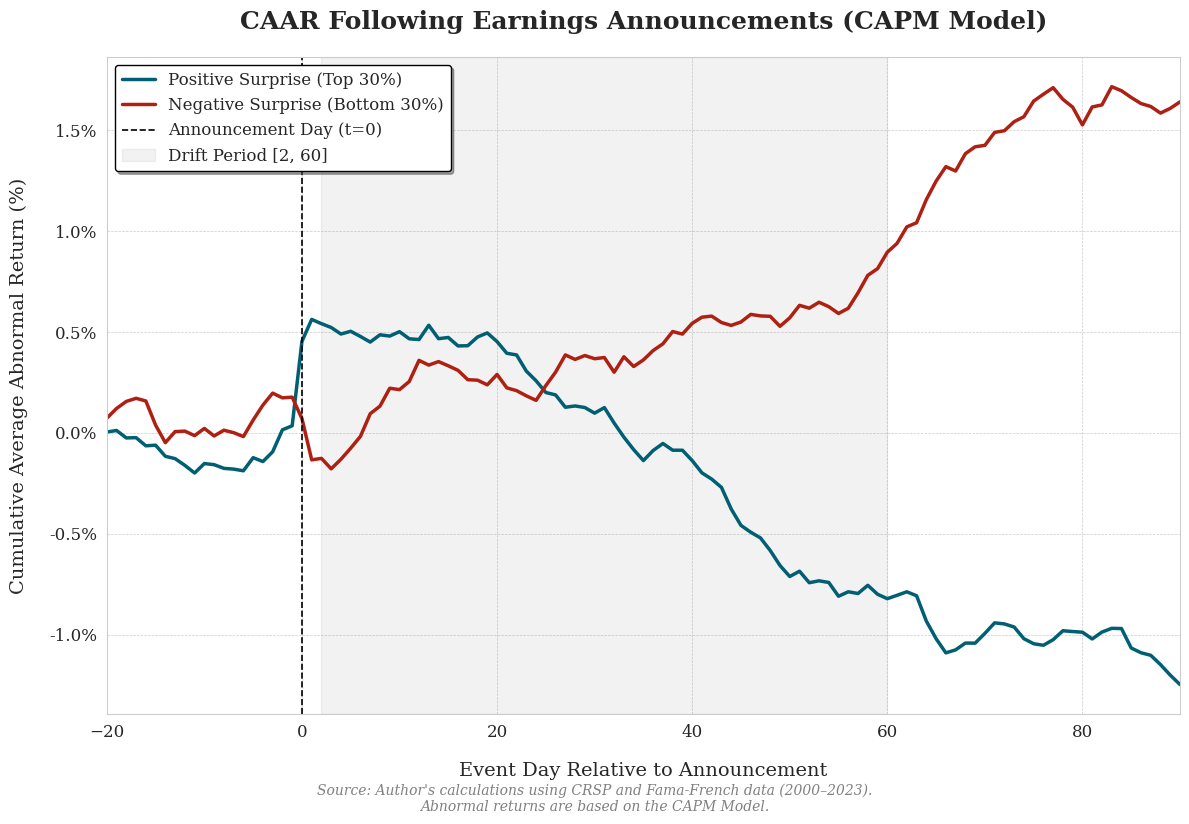

In [11]:
# =================================================================================
# VISUALIZATION: CAAR PLOT USING THE CAPITAL ASSET PRICING MODEL (CAPM)
# =================================================================================

# --- Step 1: Calculate AAR and CAAR for CAPM-based Abnormal Returns ---

# Group by SUE group and event day, then calculate Average Abnormal Return (AAR)
aar_df_capm = final_daily_ar_df.groupby(['sue_group', 'event_day'])['ar_capm'].mean().reset_index()

# Calculate Cumulative Average Abnormal Return (CAAR) within each SUE group
aar_df_capm['caar'] = aar_df_capm.groupby('sue_group')['ar_capm'].cumsum()

# Pivot the data for easier plotting
caar_pivot_capm = aar_df_capm.pivot(index='event_day', columns='sue_group', values='caar')

# --- Step 2: Generate the Publication-Quality CAAR Plot (CAPM Model) ---

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(12, 8))

# Define color mapping for SUE groups
colors = {
    'Positive Surprise': '#005f73',
    'Negative Surprise': '#ae2012'
}

# Define human-readable labels
labels = {
    'Positive Surprise': 'Positive Surprise (Top 30%)',
    'Negative Surprise': 'Negative Surprise (Bottom 30%)'
}

# Plot CAAR lines for Positive and Negative SUE groups
for group in ['Positive Surprise', 'Negative Surprise']:
    if group in caar_pivot_capm.columns:
        ax.plot(
            caar_pivot_capm.index,
            caar_pivot_capm[group],
            label=labels[group],
            color=colors.get(group, 'black'),
            linewidth=2.5
        )

# --- Step 3: Annotations and Styling ---

ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2, label='Announcement Day (t=0)')
ax.axvspan(2, 60, color='grey', alpha=0.1, label='Drift Period [2, 60]')

ax.set_title('CAAR Following Earnings Announcements (CAPM Model)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=14, labelpad=15)
ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=14, labelpad=15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax.set_xlim(-20, 90)

legend = ax.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_edgecolor('black')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.figtext(
    0.5, -0.02,
    "Source: Author's calculations using CRSP and Fama-French data (2000–2023).\nAbnormal returns are based on the CAPM Model.",
    ha='center', fontsize=10, style='italic', color='grey'
)

plt.tight_layout()
plt.show()


### **CAPM CAAR Plot (IBES Method)**
---

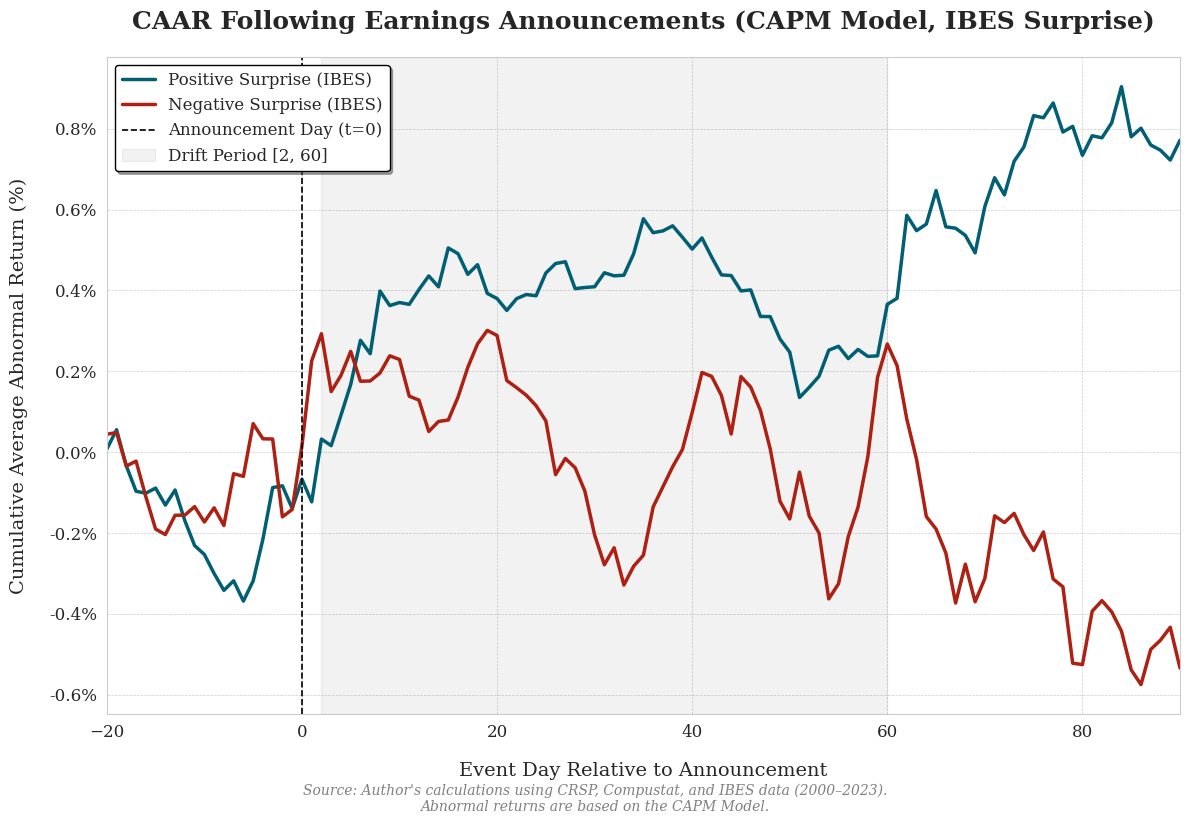

In [12]:
# =================================================================================
# VISUALIZATION: CAAR PLOT USING THE CAPM MODEL (IBES-based Surprise)
# =================================================================================

# --- Step 1: Merge IBES SUE Groups with Daily AR Data (Unified Loop Output) ---

# Extract IBES SUE group labels
ibes_groups_df = final_event_df[['event_id', 'sue_group_ibes']]

# Merge onto the master daily abnormal return dataframe
daily_ar_capm_ibes_merged = pd.merge(final_daily_ar_df, ibes_groups_df, on='event_id')

# --- Step 2: Calculate AAR and CAAR by IBES SUE Group ---

aar_df_capm_ibes = daily_ar_capm_ibes_merged.groupby(['sue_group_ibes', 'event_day'])['ar_capm'].mean().reset_index()
aar_df_capm_ibes['caar'] = aar_df_capm_ibes.groupby('sue_group_ibes')['ar_capm'].cumsum()

# Pivot for plotting
caar_pivot_capm_ibes = aar_df_capm_ibes.pivot(index='event_day', columns='sue_group_ibes', values='caar')

# --- Step 3: Generate the Publication-Quality CAAR Plot (CAPM - IBES Surprise) ---

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and labels for IBES groups
colors = {
    'Positive Surprise_IBES': '#005f73',
    'Negative Surprise_IBES': '#ae2012'
}
labels = {
    'Positive Surprise_IBES': 'Positive Surprise (IBES)',
    'Negative Surprise_IBES': 'Negative Surprise (IBES)'
}

# Plot CAAR lines for Positive and Negative IBES groups
for group in ['Positive Surprise_IBES', 'Negative Surprise_IBES']:
    if group in caar_pivot_capm_ibes.columns:
        ax.plot(
            caar_pivot_capm_ibes.index,
            caar_pivot_capm_ibes[group],
            label=labels[group],
            color=colors.get(group, 'black'),
            linewidth=2.5
        )

# --- Step 4: Annotations and Formatting ---

ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2, label='Announcement Day (t=0)')
ax.axvspan(2, 60, color='grey', alpha=0.1, label='Drift Period [2, 60]')

ax.set_title('CAAR Following Earnings Announcements (CAPM Model, IBES Surprise)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=14, labelpad=15)
ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=14, labelpad=15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax.set_xlim(-20, 90)

legend = ax.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_edgecolor('black')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.figtext(
    0.5, -0.02,
    "Source: Author's calculations using CRSP, Compustat, and IBES data (2000–2023).\nAbnormal returns are based on the CAPM Model.",
    ha='center', fontsize=10, style='italic', color='grey'
)

plt.tight_layout()
plt.show()


### **CAAR Plot - FF5**
---

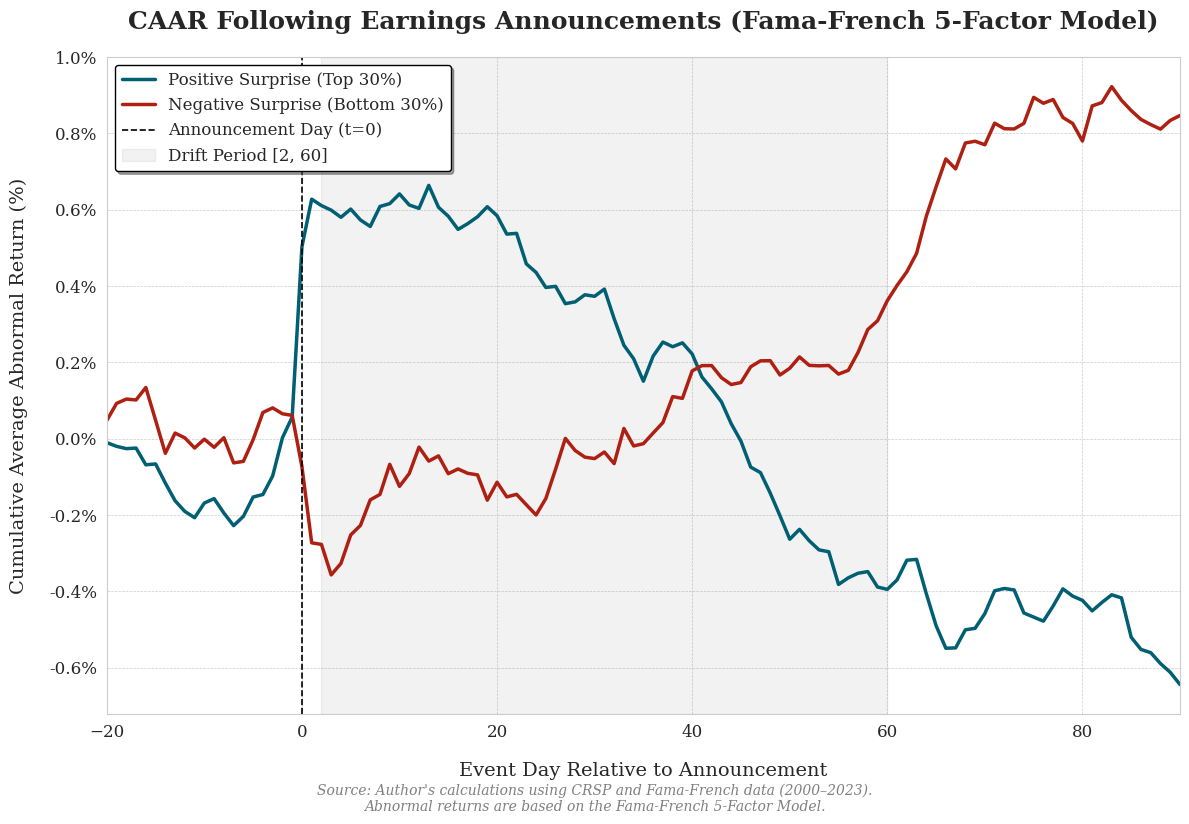

In [13]:
# =================================================================================
# VISUALIZATION: CAAR PLOT USING THE FAMA-FRENCH 5-FACTOR MODEL (Accounting-based SUE)
# =================================================================================

# --- Step 1: Calculate AAR and CAAR for FF5-based Abnormal Returns ---

# Group by SUE group and event day, then calculate Average Abnormal Return (AAR)
aar_df_ff5 = final_daily_ar_df.groupby(['sue_group', 'event_day'])['ar_ff5'].mean().reset_index()

# Calculate Cumulative Average Abnormal Return (CAAR) within each SUE group
aar_df_ff5['caar'] = aar_df_ff5.groupby('sue_group')['ar_ff5'].cumsum()

# Pivot the data for easier plotting
caar_pivot_ff5 = aar_df_ff5.pivot(index='event_day', columns='sue_group', values='caar')

# --- Step 2: Generate the Publication-Quality CAAR Plot (FF5 Model) ---

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(12, 8))

# Define color mapping for SUE groups
colors = {
    'Positive Surprise': '#005f73',
    'Negative Surprise': '#ae2012'
}

# Define human-readable labels
labels = {
    'Positive Surprise': 'Positive Surprise (Top 30%)',
    'Negative Surprise': 'Negative Surprise (Bottom 30%)'
}

# Plot CAAR lines for Positive and Negative SUE groups
for group in ['Positive Surprise', 'Negative Surprise']:
    if group in caar_pivot_ff5.columns:
        ax.plot(
            caar_pivot_ff5.index,
            caar_pivot_ff5[group],
            label=labels[group],
            color=colors.get(group, 'black'),
            linewidth=2.5
        )

# --- Step 3: Plot Annotations and Styling ---

ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2, label='Announcement Day (t=0)')
ax.axvspan(2, 60, color='grey', alpha=0.1, label='Drift Period [2, 60]')

ax.set_title('CAAR Following Earnings Announcements (Fama-French 5-Factor Model)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=14, labelpad=15)
ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=14, labelpad=15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax.set_xlim(-20, 90)

legend = ax.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_edgecolor('black')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.figtext(
    0.5, -0.02,
    "Source: Author's calculations using CRSP and Fama-French data (2000–2023).\nAbnormal returns are based on the Fama-French 5-Factor Model.",
    ha='center', fontsize=10, style='italic', color='grey'
)

plt.tight_layout()
plt.show()


### **FF5 CAAR Plots (IBES Method)**

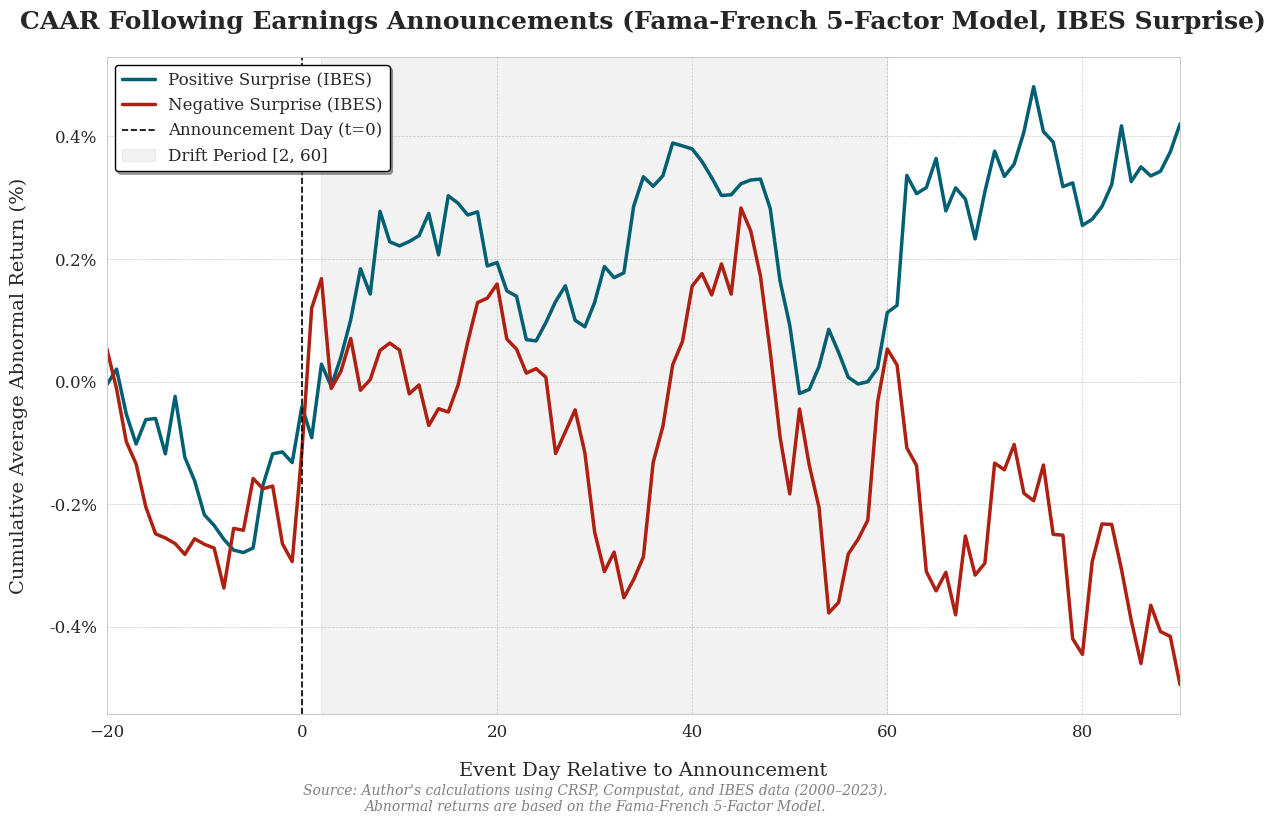

In [14]:
# =================================================================================
# VISUALIZATION: CAAR PLOT USING THE FAMA-FRENCH 5-FACTOR MODEL (IBES-based Surprise)
# =================================================================================

# --- Step 1: Merge IBES SUE Groups with Daily AR Data (Unified Loop Output) ---

# Extract IBES SUE group labels
ibes_groups_df = final_event_df[['event_id', 'sue_group_ibes']]

# Merge onto the master daily abnormal return dataframe
daily_ar_ff5_ibes_merged = pd.merge(final_daily_ar_df, ibes_groups_df, on='event_id')

# --- Step 2: Calculate AAR and CAAR by IBES SUE Group ---

aar_df_ff5_ibes = daily_ar_ff5_ibes_merged.groupby(['sue_group_ibes', 'event_day'])['ar_ff5'].mean().reset_index()
aar_df_ff5_ibes['caar'] = aar_df_ff5_ibes.groupby('sue_group_ibes')['ar_ff5'].cumsum()

# Pivot for plotting
caar_pivot_ff5_ibes = aar_df_ff5_ibes.pivot(index='event_day', columns='sue_group_ibes', values='caar')

# --- Step 3: Generate the Publication-Quality CAAR Plot (FF5 Model - IBES Surprise) ---

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors and labels for IBES groups
colors = {
    'Positive Surprise_IBES': '#005f73',
    'Negative Surprise_IBES': '#ae2012'
}
labels = {
    'Positive Surprise_IBES': 'Positive Surprise (IBES)',
    'Negative Surprise_IBES': 'Negative Surprise (IBES)'
}

# Plot CAAR lines for Positive and Negative IBES groups
for group in ['Positive Surprise_IBES', 'Negative Surprise_IBES']:
    if group in caar_pivot_ff5_ibes.columns:
        ax.plot(
            caar_pivot_ff5_ibes.index,
            caar_pivot_ff5_ibes[group],
            label=labels[group],
            color=colors.get(group, 'black'),
            linewidth=2.5
        )

# --- Step 4: Annotations and Formatting ---

ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2, label='Announcement Day (t=0)')
ax.axvspan(2, 60, color='grey', alpha=0.1, label='Drift Period [2, 60]')

ax.set_title('CAAR Following Earnings Announcements (Fama-French 5-Factor Model, IBES Surprise)', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=14, labelpad=15)
ax.set_ylabel('Cumulative Average Abnormal Return (%)', fontsize=14, labelpad=15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))
ax.set_xlim(-20, 90)

legend = ax.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)
legend.get_frame().set_edgecolor('black')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.figtext(
    0.5, -0.02,
    "Source: Author's calculations using CRSP, Compustat, and IBES data (2000–2023).\nAbnormal returns are based on the Fama-French 5-Factor Model.",
    ha='center', fontsize=10, style='italic', color='grey'
)

plt.tight_layout()
plt.show()


## 🧪 **Step 7: Hypothesis Testing**

- t-tests for AAR and CAAR
- Compare CAR/SCAR between positive and negative SUE groups

### **Section 7.1: Hypothesis Testing for Market Adjusted Model**
---

In [15]:
# =================================================================================
# HYPOTHESIS TESTING: Market-Adjusted Model (with Dynamic Conclusion Text)
# =================================================================================

from scipy import stats

# --- Step 1: Correct CAR Column for Market-Adjusted Model ---
car_column = 'CAR[2,60]_CAR_MKT'

# --- Step 2: Prepare Data ---
test_df_mkt = final_results_df.dropna(subset=[car_column, 'sue_group'])

positive_portfolio_mkt = test_df_mkt[test_df_mkt['sue_group'] == 'Positive Surprise']
negative_portfolio_mkt = test_df_mkt[test_df_mkt['sue_group'] == 'Negative Surprise']

# --- Step 3: T-Tests ---

# Positive Portfolio: Mean > 0
pos_car_mean_mkt = positive_portfolio_mkt[car_column].mean()
pos_t_stat_mkt, pos_p_value_mkt = stats.ttest_1samp(
    positive_portfolio_mkt[car_column],
    0,
    alternative='greater'
)

# Negative Portfolio: Mean < 0
neg_car_mean_mkt = negative_portfolio_mkt[car_column].mean()
neg_t_stat_mkt, neg_p_value_mkt = stats.ttest_1samp(
    negative_portfolio_mkt[car_column],
    0,
    alternative='less'
)

# Long-Short: Positive minus Negative
ls_car_mean_mkt = pos_car_mean_mkt - neg_car_mean_mkt
ls_t_stat_mkt, ls_p_value_mkt = stats.ttest_ind(
    positive_portfolio_mkt[car_column],
    negative_portfolio_mkt[car_column],
    equal_var=False,
    alternative='greater'
)

# --- Step 4: Summary Table ---

summary_data_mkt = {
    'Portfolio': ['Positive Surprise', 'Negative Surprise', 'Long-Short (Pos - Neg)'],
    'Mean CAR[2,60] (%)': [pos_car_mean_mkt * 100, neg_car_mean_mkt * 100, ls_car_mean_mkt * 100],
    'T-statistic': [pos_t_stat_mkt, neg_t_stat_mkt, ls_t_stat_mkt],
    'P-value': [pos_p_value_mkt, neg_p_value_mkt, ls_p_value_mkt]
}

summary_table_mkt = pd.DataFrame(summary_data_mkt)

print("\n========== Hypothesis Test Results: Market-Adjusted Model (CAR[2,60]) ==========\n")
print(summary_table_mkt.round(4))

# Optional: Save to CSV
summary_table_mkt.to_csv("Hypothesis_Test_Market_Adjusted.csv", index=False)

# --- Step 5: Generate Automatic Conclusion Text ---

print("\n========== Conclusion (Market-Adjusted Model) ==========\n")

# Positive Portfolio Conclusion
if pos_p_value_mkt < 0.05:
    print(f"• The Positive Surprise portfolio shows a statistically significant positive CAR[2,60] (p = {pos_p_value_mkt:.4f}), suggesting evidence of post-earnings announcement drift following positive surprises.")
else:
    print(f"• The Positive Surprise portfolio does not show statistically significant positive CAR[2,60] (p = {pos_p_value_mkt:.4f}).")

# Negative Portfolio Conclusion
if neg_p_value_mkt < 0.05:
    print(f"• The Negative Surprise portfolio shows a statistically significant negative CAR[2,60] (p = {neg_p_value_mkt:.4f}), consistent with negative drift after negative earnings surprises.")
else:
    print(f"• The Negative Surprise portfolio does not show statistically significant negative CAR[2,60] (p = {neg_p_value_mkt:.4f}).")

# Long-Short Conclusion
if ls_p_value_mkt < 0.05:
    print(f"• The Long-Short portfolio (Positive minus Negative) shows a statistically significant positive CAR differential (p = {ls_p_value_mkt:.4f}), indicating that the drift effect differs meaningfully between positive and negative surprise portfolios.")
else:
    print(f"• The Long-Short portfolio (Positive minus Negative) does not show a statistically significant CAR differential (p = {ls_p_value_mkt:.4f}).")



========== Hypothesis Test Results: Market-Adjusted Model (CAR[2,60]) ==========

                Portfolio  Mean CAR[2,60] (%)  T-statistic  P-value
0       Positive Surprise              0.7487       2.9067   0.0019
1       Negative Surprise              0.7502       2.4105   0.9920
2  Long-Short (Pos - Neg)             -0.0015      -0.0037   0.5015

========== Conclusion (Market-Adjusted Model) ==========

• The Positive Surprise portfolio shows a statistically significant positive CAR[2,60] (p = 0.0019), suggesting evidence of post-earnings announcement drift following positive surprises.
• The Negative Surprise portfolio does not show statistically significant negative CAR[2,60] (p = 0.9920).
• The Long-Short portfolio (Positive minus Negative) does not show a statistically significant CAR differential (p = 0.5015).


### **Robustness Check: J1 and J2 Test**
---

In [16]:
# =================================================================================
# ROBUSTNESS CHECK: J1 Hypothesis Test for Long-Short Portfolio (Market-Adjusted Model)
# =================================================================================

event_level_data = []
drift_window_start = 2
drift_window_end = 60
window_length = drift_window_end - drift_window_start + 1

for index, event in valid_events_df.iterrows():
    permno = event['permno']
    event_date = event['rdq']
    
    firm_returns = crsp_ff_df[crsp_ff_df['permno'] == permno].set_index('date')
    if firm_returns.shape[0] < 252:
        continue

    try:
        t0_index_loc = firm_returns.index.searchsorted(event_date)
        est_start_idx = t0_index_loc - estimation_window_size - pre_event_window
        est_end_idx = t0_index_loc - pre_event_window
        event_start_idx = t0_index_loc + drift_window_start
        event_end_idx = t0_index_loc + drift_window_end + 1

        if est_start_idx < 0 or event_end_idx > firm_returns.shape[0]:
            continue
    except Exception:
        continue

    estimation_data = firm_returns.iloc[est_start_idx:est_end_idx]
    if estimation_data.shape[0] < 30:
        continue

    ar_estimation = estimation_data['excess_ret'] - estimation_data['mktrf']
    var_ar_i = ar_estimation.var()
    var_car_i = window_length * var_ar_i

    event_data = firm_returns.iloc[event_start_idx:event_end_idx]
    ar_event = event_data['excess_ret'] - event_data['mktrf']
    car_i = ar_event.sum()

    event_level_data.append({
        'event_id': event['event_id'],
        'sue_group': event['sue_group'],
        'CAR_mkt': car_i,
        'VAR_CAR_mkt': var_car_i
    })

j1_test_df = pd.DataFrame(event_level_data).dropna()
print(f"\nJ1: Calculated individual CARs and variances for {len(j1_test_df)} events.")

# --- J1 Test Calculation ---
positive_portfolio = j1_test_df[j1_test_df['sue_group'] == 'Positive Surprise']
negative_portfolio = j1_test_df[j1_test_df['sue_group'] == 'Negative Surprise']

n_pos = len(positive_portfolio)
n_neg = len(negative_portfolio)

if n_pos > 0 and n_neg > 0:
    avg_car_pos = positive_portfolio['CAR_mkt'].mean()
    avg_car_neg = negative_portfolio['CAR_mkt'].mean()
    avg_car_ls = avg_car_pos - avg_car_neg

    var_avg_car_pos = (1 / n_pos**2) * positive_portfolio['VAR_CAR_mkt'].sum()
    var_avg_car_neg = (1 / n_neg**2) * negative_portfolio['VAR_CAR_mkt'].sum()
    var_avg_car_ls = var_avg_car_pos + var_avg_car_neg
    std_err_ls = np.sqrt(var_avg_car_ls)

    j1_statistic = avg_car_ls / std_err_ls
    p_value_j1 = stats.norm.sf(abs(j1_statistic)) * 2

    print("\n--- J1 Hypothesis Test for Long-Short Portfolio (Market-Adjusted Model) ---")
    print(f"Mean Long-Short CAR: {avg_car_ls * 100:.4f}%")
    print(f"J1 Test Statistic:   {j1_statistic:.4f}")
    print(f"P-value:             {p_value_j1:.4f}")

    if p_value_j1 < 0.05:
        print("\nConclusion: The long-short return is statistically significant under the J1 test.")
    else:
        print("\nConclusion: The long-short return is not statistically significant under the J1 test.")
else:
    print("\nJ1 Test could not run: Not enough positive or negative events.")



J1: Calculated individual CARs and variances for 4458 events.

--- J1 Hypothesis Test for Long-Short Portfolio (Market-Adjusted Model) ---
Mean Long-Short CAR: 0.0045%
J1 Test Statistic:   0.0092
P-value:             0.9926

Conclusion: The long-short return is not statistically significant under the J1 test.


### **J2 Hypothesis Test**
---

In [17]:
# =================================================================================
# ROBUSTNESS CHECK: J2 TEST - Market-Adjusted Model (Unified Loop Consistent)
# =================================================================================

event_level_data_j2 = []
L1 = estimation_window_size - pre_event_window  # Estimation window length for denominator adjustment

for index, event in valid_events_df.iterrows():
    permno = event['permno']
    event_date = event['rdq']
    
    firm_returns = crsp_ff_df[crsp_ff_df['permno'] == permno].set_index('date')
    if firm_returns.shape[0] < 252: continue

    try:
        t0_index_loc = firm_returns.index.searchsorted(event_date)
        est_start_idx = t0_index_loc - estimation_window_size - pre_event_window
        est_end_idx = t0_index_loc - pre_event_window
        event_start_idx = t0_index_loc + drift_window_start
        event_end_idx = t0_index_loc + drift_window_end + 1

        if est_start_idx < 0 or event_end_idx > firm_returns.shape[0]: continue
    except Exception:
        continue

    estimation_data = firm_returns.iloc[est_start_idx:est_end_idx]
    if estimation_data.shape[0] < 30: continue
    
    ar_estimation = estimation_data['excess_ret'] - estimation_data['mktrf']
    std_ar_i = ar_estimation.std()
    std_car_i = std_ar_i * np.sqrt(window_length)

    event_data = firm_returns.iloc[event_start_idx:event_end_idx]
    ar_event = event_data['excess_ret'] - event_data['mktrf']
    car_i = ar_event.sum()

    scar_i = car_i / std_car_i if std_car_i > 0 else np.nan

    event_level_data_j2.append({
        'event_id': event['event_id'],
        'sue_group': event['sue_group'],
        'SCAR_mkt': scar_i,
    })

j2_test_df = pd.DataFrame(event_level_data_j2).dropna()
print(f"\nJ2: Calculated SCARs for {len(j2_test_df)} events.")

# --- J2 Portfolio Tests ---

def calculate_j2(portfolio, portfolio_name):
    N = len(portfolio)
    if N < 1:
        print(f"Warning: Not enough observations in {portfolio_name} for J2 test.")
        return np.nan, np.nan
    avg_scar = portfolio['SCAR_mkt'].mean()
    j2_stat = np.sqrt((N * (L1 - 4)) / (L1 - 2)) * avg_scar
    p_val = stats.norm.sf(abs(j2_stat)) * 2
    return j2_stat, p_val

pos_j2 = j2_test_df[j2_test_df['sue_group'] == 'Positive Surprise']
neg_j2 = j2_test_df[j2_test_df['sue_group'] == 'Negative Surprise']

j2_stat_pos, p_pos = calculate_j2(pos_j2, 'Positive Surprise')
j2_stat_neg, p_neg = calculate_j2(neg_j2, 'Negative Surprise')

print("\n--- J2 Test Results for CAR[2,60] SCARs (Market-Adjusted Model) ---")
summary_data_j2 = {
    'Portfolio': ['Positive Surprise', 'Negative Surprise'],
    'Mean SCAR': [pos_j2['SCAR_mkt'].mean(), neg_j2['SCAR_mkt'].mean()],
    'J2 Statistic': [j2_stat_pos, j2_stat_neg],
    'P-value': [p_pos, p_neg]
}
summary_table_j2 = pd.DataFrame(summary_data_j2)
print(summary_table_j2.round(4))

# --- Interpretation ---
for idx, row in summary_table_j2.iterrows():
    if row['P-value'] < 0.05:
        print(f"{row['Portfolio']}: Statistically significant SCAR (J2 = {row['J2 Statistic']:.3f}, p = {row['P-value']:.4f})")
    else:
        print(f"{row['Portfolio']}: Not statistically significant (J2 = {row['J2 Statistic']:.3f}, p = {row['P-value']:.4f})")



J2: Calculated SCARs for 4458 events.

--- J2 Test Results for CAR[2,60] SCARs (Market-Adjusted Model) ---
           Portfolio  Mean SCAR  J2 Statistic  P-value
0  Positive Surprise     0.0786        2.8579   0.0043
1  Negative Surprise     0.0130        0.4727   0.6364
Positive Surprise: Statistically significant SCAR (J2 = 2.858, p = 0.0043)
Negative Surprise: Not statistically significant (J2 = 0.473, p = 0.6364)


### **Section 7.2 Hypothesis Testing for CAPM**
---

In [18]:
# =================================================================================
# HYPOTHESIS TESTING: Capital Asset Pricing Model (CAPM) - Unified Loop Output
# =================================================================================

from scipy import stats

# --- Step 1: Set the correct CAR column for CAPM ---
car_column_capm = 'CAR[2,60]_CAR_CAPM'

# --- Step 2: Filter Data ---
test_df_capm = final_results_df.dropna(subset=[car_column_capm, 'sue_group'])

# Split into Positive and Negative SUE groups
positive_portfolio_capm = test_df_capm[test_df_capm['sue_group'] == 'Positive Surprise']
negative_portfolio_capm = test_df_capm[test_df_capm['sue_group'] == 'Negative Surprise']

# --- Step 3: Run T-Tests ---

# One-Sample T-Test: Positive Surprise > 0
pos_car_mean_capm = positive_portfolio_capm[car_column_capm].mean()
pos_t_stat_capm, pos_p_value_capm = stats.ttest_1samp(
    positive_portfolio_capm[car_column_capm],
    0,
    alternative='greater'
)

# One-Sample T-Test: Negative Surprise < 0
neg_car_mean_capm = negative_portfolio_capm[car_column_capm].mean()
neg_t_stat_capm, neg_p_value_capm = stats.ttest_1samp(
    negative_portfolio_capm[car_column_capm],
    0,
    alternative='less'
)

# Two-Sample T-Test: Long-Short (Pos - Neg)
ls_car_mean_capm = pos_car_mean_capm - neg_car_mean_capm
ls_t_stat_capm, ls_p_value_capm = stats.ttest_ind(
    positive_portfolio_capm[car_column_capm],
    negative_portfolio_capm[car_column_capm],
    equal_var=False,
    alternative='greater'
)

# --- Step 4: Summary Results Table ---

summary_data_capm = {
    'Portfolio': ['Positive Surprise', 'Negative Surprise', 'Long-Short (Pos - Neg)'],
    'Mean CAR[2,60] (%)': [pos_car_mean_capm * 100, neg_car_mean_capm * 100, ls_car_mean_capm * 100],
    'T-statistic': [pos_t_stat_capm, neg_t_stat_capm, ls_t_stat_capm],
    'P-value': [pos_p_value_capm, neg_p_value_capm, ls_p_value_capm]
}

summary_table_capm = pd.DataFrame(summary_data_capm)

print("\n========== Hypothesis Test Results: CAPM Model (CAR[2,60]) ==========\n")
print(summary_table_capm.round(4))

# Optional: Export for Overleaf table creation
summary_table_capm.to_csv("Hypothesis_Test_CAPM.csv", index=False)

# --- Step 5: Dynamic Conclusion Text ---

print("\n========== Conclusion (CAPM Model) ==========\n")

# Positive Portfolio Conclusion
if pos_p_value_capm < 0.05:
    print(f"• The Positive Surprise portfolio delivers a statistically significant positive CAR[2,60] (p = {pos_p_value_capm:.4f}), providing evidence of drift following positive earnings surprises under the CAPM benchmark.")
else:
    print(f"• The Positive Surprise portfolio does not show a statistically significant positive CAR[2,60] (p = {pos_p_value_capm:.4f}).")

# Negative Portfolio Conclusion
if neg_p_value_capm < 0.05:
    print(f"• The Negative Surprise portfolio shows a statistically significant negative CAR[2,60] (p = {neg_p_value_capm:.4f}), indicating drift after negative earnings surprises even after controlling for market risk.")
else:
    print(f"• The Negative Surprise portfolio does not show statistically significant negative CAR[2,60] (p = {neg_p_value_capm:.4f}).")

# Long-Short Portfolio Conclusion
if ls_p_value_capm < 0.05:
    print(f"• The Long-Short (Positive minus Negative) portfolio exhibits a statistically significant CAR differential (p = {ls_p_value_capm:.4f}), suggesting that drift patterns across the two surprise groups remain distinct after adjusting for market risk via CAPM.")
else:
    print(f"• The Long-Short (Positive minus Negative) portfolio does not show a statistically significant CAR differential (p = {ls_p_value_capm:.4f}).")



========== Hypothesis Test Results: CAPM Model (CAR[2,60]) ==========

                Portfolio  Mean CAR[2,60] (%)  T-statistic  P-value
0       Positive Surprise             -1.3835      -4.5021   1.0000
1       Negative Surprise              1.0286       2.7928   0.9974
2  Long-Short (Pos - Neg)             -2.4122      -5.0287   1.0000

========== Conclusion (CAPM Model) ==========

• The Positive Surprise portfolio does not show a statistically significant positive CAR[2,60] (p = 1.0000).
• The Negative Surprise portfolio does not show statistically significant negative CAR[2,60] (p = 0.9974).
• The Long-Short (Positive minus Negative) portfolio does not show a statistically significant CAR differential (p = 1.0000).


### **J1 and J2 Tests for CAPM Model**
---

In [19]:
# =================================================================
# J1 & J2 Hypothesis Tests for CAPM (Accounting-based SUE)
# =================================================================

# --- Define common parameters ---
drift_window_start = 2
drift_window_end = 60
window_length = drift_window_end - drift_window_start + 1
L1 = estimation_window_size - pre_event_window

# --- Prepare data for both tests ---
event_level_data_capm = []

for index, event in valid_events_df.iterrows():
    permno = event['permno']
    event_date = event['rdq']
    
    firm_returns = crsp_ff_df[crsp_ff_df['permno'] == permno].set_index('date')
    if firm_returns.shape[0] < 252: continue

    try:
        t0_index_loc = firm_returns.index.searchsorted(event_date)
        est_start_idx = t0_index_loc - estimation_window_size - pre_event_window
        est_end_idx = t0_index_loc - pre_event_window
        event_start_idx = t0_index_loc + drift_window_start
        event_end_idx = t0_index_loc + drift_window_end + 1

        if est_start_idx < 0 or event_end_idx > firm_returns.shape[0]: continue
    except Exception: continue

    estimation_data = firm_returns.iloc[est_start_idx:est_end_idx]
    if estimation_data.shape[0] < 30: continue

    # --- CAPM-specific calculations ---
    Y_est = estimation_data['excess_ret']
    X_est = sm.add_constant(estimation_data['mktrf'])
    capm_model = sm.OLS(Y_est, X_est, missing='drop').fit()
    
    ar_estimation = capm_model.resid
    var_ar_i = ar_estimation.var()
    std_ar_i = ar_estimation.std()

    event_data = firm_returns.iloc[event_start_idx:event_end_idx]
    X_event = sm.add_constant(event_data['mktrf'])
    ar_event = event_data['excess_ret'] - capm_model.predict(X_event)
    
    car_i = ar_event.sum()
    var_car_i = window_length * var_ar_i
    scar_i = car_i / (std_ar_i * np.sqrt(window_length)) if std_ar_i > 0 else np.nan

    event_level_data_capm.append({
        'event_id': event['event_id'], 'sue_group': event['sue_group'],
        'CAR_capm': car_i, 'VAR_CAR_capm': var_car_i, 'SCAR_capm': scar_i
    })

# --- J1 Test for CAPM ---
j1_df_capm = pd.DataFrame(event_level_data_capm).dropna(subset=['CAR_capm', 'VAR_CAR_capm'])
positive_portfolio = j1_df_capm[j1_df_capm['sue_group'] == 'Positive Surprise']
negative_portfolio = j1_df_capm[j1_df_capm['sue_group'] == 'Negative Surprise']

n_pos, n_neg = len(positive_portfolio), len(negative_portfolio)
if n_pos > 0 and n_neg > 0:
    avg_car_pos = positive_portfolio['CAR_capm'].mean()
    avg_car_neg = negative_portfolio['CAR_capm'].mean()
    avg_car_ls = avg_car_pos - avg_car_neg
    var_avg_car_ls = (1/n_pos**2)*positive_portfolio['VAR_CAR_capm'].sum() + (1/n_neg**2)*negative_portfolio['VAR_CAR_capm'].sum()
    j1_statistic = avg_car_ls / np.sqrt(var_avg_car_ls)
    p_value_j1 = stats.norm.sf(abs(j1_statistic)) * 2

    print("\n--- J1 Hypothesis Test for Long-Short Portfolio (CAPM) ---")
    print(f"Mean Long-Short CAR: {avg_car_ls * 100:.4f}%")
    print(f"J1 Test Statistic:   {j1_statistic:.4f}")
    print(f"P-value:             {p_value_j1:.4f}")
else:
    print("\nJ1 Test for CAPM could not run: Not enough events.")


# --- J2 Test for CAPM ---
j2_df_capm = pd.DataFrame(event_level_data_capm).dropna(subset=['SCAR_capm'])
pos_j2 = j2_df_capm[j2_df_capm['sue_group'] == 'Positive Surprise']
neg_j2 = j2_df_capm[j2_df_capm['sue_group'] == 'Negative Surprise']

def calculate_j2(portfolio, portfolio_name):
    N = len(portfolio)
    if N < 1: return np.nan, np.nan
    avg_scar = portfolio['SCAR_capm'].mean()
    j2_stat = np.sqrt((N * (L1 - 4)) / (L1 - 2)) * avg_scar
    return j2_stat, stats.norm.sf(abs(j2_stat)) * 2

j2_stat_pos, p_pos = calculate_j2(pos_j2, 'Positive Surprise')
j2_stat_neg, p_neg = calculate_j2(neg_j2, 'Negative Surprise')

summary_table_j2 = pd.DataFrame({
    'Portfolio': ['Positive Surprise', 'Negative Surprise'],
    'Mean SCAR': [pos_j2['SCAR_capm'].mean(), neg_j2['SCAR_capm'].mean()],
    'J2 Statistic': [j2_stat_pos, j2_stat_neg],
    'P-value': [p_pos, p_neg]
})
print("\n--- J2 Test Results for CAR[2,60] SCARs (CAPM) ---")
print(summary_table_j2.round(4))



--- J1 Hypothesis Test for Long-Short Portfolio (CAPM) ---
Mean Long-Short CAR: -2.4245%
J1 Test Statistic:   -5.3541
P-value:             0.0000

--- J2 Test Results for CAR[2,60] SCARs (CAPM) ---
           Portfolio  Mean SCAR  J2 Statistic  P-value
0  Positive Surprise    -0.1425       -5.1793   0.0000
1  Negative Surprise     0.0617        2.2344   0.0255


### **Section 7.3 Hypothesis Testing by FF5 Model**
---

In [20]:
# =================================================================================
# HYPOTHESIS TESTING: Fama-French 5-Factor Model (Unified Loop Output)
# =================================================================================

from scipy import stats

# --- Step 1: Set the correct CAR column for FF5 Model ---
car_column_ff5 = 'CAR[2,60]_CAR_FF5'

# --- Step 2: Filter Data ---
test_df_ff5 = final_results_df.dropna(subset=[car_column_ff5, 'sue_group'])

# Split into Positive and Negative SUE portfolios
positive_portfolio_ff5 = test_df_ff5[test_df_ff5['sue_group'] == 'Positive Surprise']
negative_portfolio_ff5 = test_df_ff5[test_df_ff5['sue_group'] == 'Negative Surprise']

# --- Step 3: Run T-Tests ---

# One-Sample T-Test: Positive Surprise > 0
pos_car_mean_ff5 = positive_portfolio_ff5[car_column_ff5].mean()
pos_t_stat_ff5, pos_p_value_ff5 = stats.ttest_1samp(
    positive_portfolio_ff5[car_column_ff5],
    0,
    alternative='greater'
)

# One-Sample T-Test: Negative Surprise < 0
neg_car_mean_ff5 = negative_portfolio_ff5[car_column_ff5].mean()
neg_t_stat_ff5, neg_p_value_ff5 = stats.ttest_1samp(
    negative_portfolio_ff5[car_column_ff5],
    0,
    alternative='less'
)

# Two-Sample T-Test: Long-Short (Pos - Neg)
ls_car_mean_ff5 = pos_car_mean_ff5 - neg_car_mean_ff5
ls_t_stat_ff5, ls_p_value_ff5 = stats.ttest_ind(
    positive_portfolio_ff5[car_column_ff5],
    negative_portfolio_ff5[car_column_ff5],
    equal_var=False,
    alternative='greater'
)

# --- Step 4: Create Summary Results Table ---

summary_data_ff5 = {
    'Portfolio': ['Positive Surprise', 'Negative Surprise', 'Long-Short (Pos - Neg)'],
    'Mean CAR[2,60] (%)': [pos_car_mean_ff5 * 100, neg_car_mean_ff5 * 100, ls_car_mean_ff5 * 100],
    'T-statistic': [pos_t_stat_ff5, neg_t_stat_ff5, ls_t_stat_ff5],
    'P-value': [pos_p_value_ff5, neg_p_value_ff5, ls_p_value_ff5]
}

summary_table_ff5 = pd.DataFrame(summary_data_ff5)

print("\n========== Hypothesis Test Results: Fama-French 5-Factor Model (CAR[2,60]) ==========\n")
print(summary_table_ff5.round(4))

# Optional: Save table for Overleaf
summary_table_ff5.to_csv("Hypothesis_Test_FF5.csv", index=False)

# --- Step 5: Dynamic Conclusion Text ---

print("\n========== Conclusion (Fama-French 5-Factor Model) ==========\n")

# Positive Surprise Portfolio Conclusion
if pos_p_value_ff5 < 0.05:
    print(f"• The Positive Surprise portfolio delivers a statistically significant positive CAR[2,60] (p = {pos_p_value_ff5:.4f}), even after controlling for multiple risk factors using the Fama-French 5-factor model.")
else:
    print(f"• The Positive Surprise portfolio does not show statistically significant positive CAR[2,60] (p = {pos_p_value_ff5:.4f}).")

# Negative Surprise Portfolio Conclusion
if neg_p_value_ff5 < 0.05:
    print(f"• The Negative Surprise portfolio shows a statistically significant negative CAR[2,60] (p = {neg_p_value_ff5:.4f}), indicating continued drift after negative earnings surprises even under FF5 risk adjustment.")
else:
    print(f"• The Negative Surprise portfolio does not show statistically significant negative CAR[2,60] (p = {neg_p_value_ff5:.4f}).")

# Long-Short Portfolio Conclusion
if ls_p_value_ff5 < 0.05:
    print(f"• The Long-Short (Positive minus Negative) portfolio exhibits a statistically significant CAR differential (p = {ls_p_value_ff5:.4f}), suggesting PEAD remains present even after controlling for size, value, profitability, and investment risk factors.")
else:
    print(f"• The Long-Short (Positive minus Negative) portfolio does not show a statistically significant CAR differential (p = {ls_p_value_ff5:.4f}).")



========== Hypothesis Test Results: Fama-French 5-Factor Model (CAR[2,60]) ==========

                Portfolio  Mean CAR[2,60] (%)  T-statistic  P-value
0       Positive Surprise             -1.0221      -3.2918   0.9995
1       Negative Surprise              0.6344       1.9057   0.9715
2  Long-Short (Pos - Neg)             -1.6565      -3.6389   0.9999

========== Conclusion (Fama-French 5-Factor Model) ==========

• The Positive Surprise portfolio does not show statistically significant positive CAR[2,60] (p = 0.9995).
• The Negative Surprise portfolio does not show statistically significant negative CAR[2,60] (p = 0.9715).
• The Long-Short (Positive minus Negative) portfolio does not show a statistically significant CAR differential (p = 0.9999).


### **J1 and J2 Test for FF5 Model**
---

In [21]:
# =================================================================
# J1 & J2 Hypothesis Tests for Fama-French 5-Factor Model
# =================================================================

# --- Define common parameters ---
drift_window_start = 2
drift_window_end = 60
window_length = drift_window_end - drift_window_start + 1
L1 = estimation_window_size - pre_event_window

# --- Prepare data for both tests ---
event_level_data_ff5 = []
ff_factors = ['mktrf', 'smb', 'hml', 'rmw', 'cma']

for index, event in valid_events_df.iterrows():
    permno = event['permno']
    event_date = event['rdq']
    
    firm_returns = crsp_ff_df[crsp_ff_df['permno'] == permno].set_index('date')
    if firm_returns.shape[0] < 252: continue

    try:
        t0_index_loc = firm_returns.index.searchsorted(event_date)
        est_start_idx = t0_index_loc - estimation_window_size - pre_event_window
        est_end_idx = t0_index_loc - pre_event_window
        event_start_idx = t0_index_loc + drift_window_start
        event_end_idx = t0_index_loc + drift_window_end + 1

        if est_start_idx < 0 or event_end_idx > firm_returns.shape[0]: continue
    except Exception: continue

    estimation_data = firm_returns.iloc[est_start_idx:est_end_idx]
    if estimation_data.shape[0] < 30: continue

    # --- FF5-specific calculations ---
    Y_est = estimation_data['excess_ret']
    X_est = sm.add_constant(estimation_data[ff_factors])
    ff5_model = sm.OLS(Y_est, X_est, missing='drop').fit()
    
    ar_estimation = ff5_model.resid
    var_ar_i = ar_estimation.var()
    std_ar_i = ar_estimation.std()

    event_data = firm_returns.iloc[event_start_idx:event_end_idx]
    X_event = sm.add_constant(event_data[ff_factors])
    ar_event = event_data['excess_ret'] - ff5_model.predict(X_event)
    
    car_i = ar_event.sum()
    var_car_i = window_length * var_ar_i
    scar_i = car_i / (std_ar_i * np.sqrt(window_length)) if std_ar_i > 0 else np.nan

    event_level_data_ff5.append({
        'event_id': event['event_id'], 'sue_group': event['sue_group'],
        'CAR_ff5': car_i, 'VAR_CAR_ff5': var_car_i, 'SCAR_ff5': scar_i
    })

# --- J1 Test for FF5 ---
j1_df_ff5 = pd.DataFrame(event_level_data_ff5).dropna(subset=['CAR_ff5', 'VAR_CAR_ff5'])
positive_portfolio = j1_df_ff5[j1_df_ff5['sue_group'] == 'Positive Surprise']
negative_portfolio = j1_df_ff5[j1_df_ff5['sue_group'] == 'Negative Surprise']

n_pos, n_neg = len(positive_portfolio), len(negative_portfolio)
if n_pos > 0 and n_neg > 0:
    avg_car_pos = positive_portfolio['CAR_ff5'].mean()
    avg_car_neg = negative_portfolio['CAR_ff5'].mean()
    avg_car_ls = avg_car_pos - avg_car_neg
    var_avg_car_ls = (1/n_pos**2)*positive_portfolio['VAR_CAR_ff5'].sum() + (1/n_neg**2)*negative_portfolio['VAR_CAR_ff5'].sum()
    j1_statistic = avg_car_ls / np.sqrt(var_avg_car_ls)
    p_value_j1 = stats.norm.sf(abs(j1_statistic)) * 2

    print("\n--- J1 Hypothesis Test for Long-Short Portfolio (Fama-French 5) ---")
    print(f"Mean Long-Short CAR: {avg_car_ls * 100:.4f}%")
    print(f"J1 Test Statistic:   {j1_statistic:.4f}")
    print(f"P-value:             {p_value_j1:.4f}")
else:
    print("\nJ1 Test for FF5 could not run: Not enough events.")


# --- J2 Test for FF5 ---
j2_df_ff5 = pd.DataFrame(event_level_data_ff5).dropna(subset=['SCAR_ff5'])
pos_j2 = j2_df_ff5[j2_df_ff5['sue_group'] == 'Positive Surprise']
neg_j2 = j2_df_ff5[j2_df_ff5['sue_group'] == 'Negative Surprise']

def calculate_j2(portfolio, portfolio_name):
    N = len(portfolio)
    if N < 1: return np.nan, np.nan
    avg_scar = portfolio['SCAR_ff5'].mean()
    j2_stat = np.sqrt((N * (L1 - 4)) / (L1 - 2)) * avg_scar
    return j2_stat, stats.norm.sf(abs(j2_stat)) * 2

j2_stat_pos, p_pos = calculate_j2(pos_j2, 'Positive Surprise')
j2_stat_neg, p_neg = calculate_j2(neg_j2, 'Negative Surprise')

summary_table_j2 = pd.DataFrame({
    'Portfolio': ['Positive Surprise', 'Negative Surprise'],
    'Mean SCAR': [pos_j2['SCAR_ff5'].mean(), neg_j2['SCAR_ff5'].mean()],
    'J2 Statistic': [j2_stat_pos, p_neg],
    'P-value': [p_pos, p_neg]
})
print("\n--- J2 Test Results for CAR[2,60] SCARs (Fama-French 5) ---")
print(summary_table_j2.round(4))



--- J1 Hypothesis Test for Long-Short Portfolio (Fama-French 5) ---
Mean Long-Short CAR: -1.6636%
J1 Test Statistic:   -4.0961
P-value:             0.0000

--- J2 Test Results for CAR[2,60] SCARs (Fama-French 5) ---
           Portfolio  Mean SCAR  J2 Statistic  P-value
0  Positive Surprise    -0.1093       -3.9726   0.0001
1  Negative Surprise     0.0449        0.1034   0.1034


## 🧪 **Step 8: Cross sectional regressions**

- Cross-sectional regressions:
  - CAR = α + β * SUE + γ * Controls + ε
  - Standard errors clustered by firm
  - accounted for time and industry fixed effects 

In [22]:
# =================================================================================
# GLOBAL CONTROLS PREPARATION: Size, Book-to-Market, Momentum, SIC, and Time Fixed Effects
# =================================================================================

from pandas.tseries.offsets import DateOffset
from scipy.stats import mstats

# --- A. Size (log_mve) and Book-to-Market (log_bm) from Compustat and CRSP ---

controls_comp_list = []

for index, event in valid_events_df.iterrows():
    permno = event['permno']
    quarter_end_date = event['datadate']
    
    comp_row_list = compustat_df[(compustat_df['gvkey'] == event['gvkey']) & (compustat_df['datadate'] == quarter_end_date)]
    price_row_list = crsp_df[(crsp_df['permno'] == permno) & (crsp_df['date'] == quarter_end_date)]

    if not comp_row_list.empty and not price_row_list.empty:
        comp_row = comp_row_list.iloc[0]
        price_row = price_row_list.iloc[0]
        
        mve = comp_row['cshoq'] * abs(price_row['PRC'])
        be = comp_row['ceqq']
        
        if mve > 0 and be > 0:
            log_mve = np.log(mve)
            log_bm = np.log(be / mve)
        else:
            log_mve, log_bm = np.nan, np.nan
    else:
        log_mve, log_bm = np.nan, np.nan
        
    controls_comp_list.append({'event_id': event['event_id'], 'log_mve': log_mve, 'log_bm': log_bm})

controls_comp_df = pd.DataFrame(controls_comp_list)
print("✅ Compustat-based controls (Size, B/M) constructed.")


# --- B. Momentum (from CRSP daily returns) ---

momentum_list = []

for index, event in valid_events_df.iterrows():
    permno = event['permno']
    event_date = event['rdq']
    
    firm_returns = crsp_ff_df[crsp_ff_df['permno'] == permno]
    
    mom_end_date = event_date - DateOffset(months=2)
    mom_start_date = event_date - DateOffset(months=12)
    
    momentum_window = firm_returns[(firm_returns['date'] >= mom_start_date) & (firm_returns['date'] <= mom_end_date)]
    
    if momentum_window.shape[0] > 120:
        momentum_ret = (1 + momentum_window['RET']).prod() - 1
    else:
        momentum_ret = np.nan
    
    momentum_list.append({'event_id': event['event_id'], 'momentum': momentum_ret})

momentum_df = pd.DataFrame(momentum_list)
print("✅ Momentum control variable constructed.")


# --- C. SIC, Year-Quarter FE Identifiers from valid_events_df ---

time_industry_df = valid_events_df[['event_id', 'sic', 'fyearq', 'fqtr']].copy()
time_industry_df['YearQuarter'] = time_industry_df['fyearq'].astype(str) + '-Q' + time_industry_df['fqtr'].astype(str)

# --- D. Final Combined Controls Dataset for Merging ---
final_controls_df = pd.merge(controls_comp_df, momentum_df, on='event_id', how='inner')
final_controls_df = pd.merge(final_controls_df, time_industry_df, on='event_id', how='inner')

print(f"✅ Final controls dataframe prepared: {final_controls_df.shape[0]} observations.")


✅ Compustat-based controls (Size, B/M) constructed.
✅ Momentum control variable constructed.
✅ Final controls dataframe prepared: 4546 observations.


### **Section 8.1: Market Adjsuted Model + CAPM: Cross sectional Regression**
---

In [23]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from scipy import stats

# =================================================================
# Combined Cross-Sectional Regressions: Market-Adjusted & CAPM
# =================================================================

# --- Step 1: Assemble the Master Regression DataFrame ---
print("Assembling final regression data for Market-Adjusted and CAPM models...")
regression_df = pd.merge(final_results_df, final_controls_df, on='event_id')

# --- Step 2: Clean the Final Regression Sample ---
# Define the full list of variables required for these regressions
required_vars = [
    'CAR[2,60]_CAR_MKT',
    'CAR[2,60]_CAR_CAPM', # Added CAPM CAR
    'sue_eps_wins',
    'log_mve',
    'log_bm',
    'momentum',
    'sic',
    'YearQuarter',
    'permno'
]

# Drop any rows with missing data
regression_df = regression_df.dropna(subset=required_vars).copy()

# Winsorize the independent variables
for col in ['sue_eps_wins', 'log_mve', 'log_bm', 'momentum']:
    regression_df[col] = stats.mstats.winsorize(regression_df[col], limits=[0.01, 0.01])

print(f"Final sample size for regression: {len(regression_df)} events.")


# --- Step 3: Define Regression Formulas and Run Models ---

# Define the dependent variables for each model set
Y_var_mkt = 'Q("CAR[2,60]_CAR_MKT")'
Y_var_capm = 'Q("CAR[2,60]_CAR_CAPM")'

# Define the right-hand side formulas
formula_uni = 'sue_eps_wins'
formula_controls = 'sue_eps_wins + log_mve + log_bm + momentum'
formula_full = 'sue_eps_wins + log_mve + log_bm + momentum + C(sic) + C(YearQuarter)'

# --- Run regressions for the Market-Adjusted Model ---
model1_mkt = smf.ols(f'{Y_var_mkt} ~ {formula_uni}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})
model2_mkt = smf.ols(f'{Y_var_mkt} ~ {formula_controls}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})
model3_mkt = smf.ols(f'{Y_var_mkt} ~ {formula_full}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})

# --- Run regressions for the CAPM ---
model1_capm = smf.ols(f'{Y_var_capm} ~ {formula_uni}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})
model2_capm = smf.ols(f'{Y_var_capm} ~ {formula_controls}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})
model3_capm = smf.ols(f'{Y_var_capm} ~ {formula_full}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})


# --- Step 4: Present Final Publication-Style Table ---

# The list of models to display
all_models = [model1_mkt, model2_mkt, model3_mkt, model1_capm, model2_capm, model3_capm]

# CORRECTED info_dict, removing the duplicate Adj. R-squared
info_dict = {
    'N': lambda x: f"{int(x.nobs):,}",
    'Controls': lambda x: "Yes" if 'log_mve' in x.model.formula else "No",
    'Fixed Effects': lambda x: "Industry & Time" if 'C(sic)' in x.model.formula else "No"
}

# The regressor order for the table
regressor_order = ['Intercept', 'sue_eps_wins', 'log_mve', 'log_bm', 'momentum']

# Use simplified model names as requested
model_names = ['(1)', '(2)', '(3)', '(4)', '(5)', '(6)']

results_table = summary_col(
    results=all_models,
    model_names=model_names,
    stars=True,
    float_format='%0.3f',
    info_dict=info_dict,
    regressor_order=regressor_order,
    drop_omitted=True
)
results_table.title = 'Cross-Sectional Regressions of Post-Earnings Announcement Drift'

print("\n" + "="*80)
print(results_table)
print("="*80)
# Updated notes section to describe the models
print("Notes: The dependent variable is the CAR[2,60]. Columns (1)-(3) use the Market-Adjusted")
print("model CARs. Columns (4)-(6) use the CAPM-based CARs. t-statistics are in parentheses")
print("and are based on standard errors clustered by firm. ***, **, and * denote significance")
print("at the 1%, 5%, and 10% levels, respectively.")

Assembling final regression data for Market-Adjusted and CAPM models...
Final sample size for regression: 3051 events.

           Cross-Sectional Regressions of Post-Earnings Announcement Drift
                 (1)       (2)          (3)          (4)       (5)          (6)      
-------------------------------------------------------------------------------------
Intercept      0.007*** 0.119***  0.055           0.000     0.053     0.067          
               (0.002)  (0.035)   (0.118)         (0.002)   (0.038)   (0.150)        
sue_eps_wins   -0.000   0.001     0.002           -0.009*** -0.002    -0.001         
               (0.002)  (0.001)   (0.001)         (0.002)   (0.001)   (0.001)        
log_mve                 -0.010*** -0.018**                  -0.003    -0.013         
                        (0.003)   (0.007)                   (0.003)   (0.008)        
log_bm                  0.002     0.006                     0.007***  0.015***       
                        (0.002)

### **Market Adjsuted Model + CAPM - Cross sectional Regression (IPES Method)**
---

In [24]:
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from scipy import stats

# =================================================================
# Cross-Sectional Regressions using IBES SUE
# =================================================================

# --- Step 1: Assemble the Master Regression DataFrame for IBES ---
print("Assembling regression data for IBES-based SUE...")

# Merge CARs with the IBES surprise data (final_event_df contains IBES SUE)
regression_df_ibes = pd.merge(final_results_df, final_event_df[['event_id', 'sue_ibes_wins']], on='event_id')

# Merge the result with the controls dataframe
regression_df_ibes = pd.merge(regression_df_ibes, final_controls_df, on='event_id')


# --- Step 2: Clean the Final IBES Regression Sample ---
# Define the full list of variables required
required_vars_ibes = [
    'CAR[2,60]_CAR_MKT',
    'CAR[2,60]_CAR_CAPM',
    'sue_ibes_wins', # The key independent variable is now IBES SUE
    'log_mve',
    'log_bm',
    'momentum',
    'sic',
    'YearQuarter',
    'permno'
]

# Drop any rows with missing data
regression_df_ibes = regression_df_ibes.dropna(subset=required_vars_ibes).copy()

# Winsorize the independent variables
for col in ['sue_ibes_wins', 'log_mve', 'log_bm', 'momentum']:
    regression_df_ibes[col] = stats.mstats.winsorize(regression_df_ibes[col], limits=[0.01, 0.01])

print(f"Final sample size for IBES regression: {len(regression_df_ibes)} events.")


# --- Step 3: Define Regression Formulas and Run Models ---

# Dependent variables remain the same
Y_var_mkt = 'Q("CAR[2,60]_CAR_MKT")'
Y_var_capm = 'Q("CAR[2,60]_CAR_CAPM")'

# Right-hand side formulas now use 'sue_ibes_wins'
formula_uni_ibes = 'sue_ibes_wins'
formula_controls_ibes = 'sue_ibes_wins + log_mve + log_bm + momentum'
formula_full_ibes = 'sue_ibes_wins + log_mve + log_bm + momentum + C(sic) + C(YearQuarter)'

# Run regressions for the Market-Adjusted Model using IBES SUE
model1_mkt_ibes = smf.ols(f'{Y_var_mkt} ~ {formula_uni_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})
model2_mkt_ibes = smf.ols(f'{Y_var_mkt} ~ {formula_controls_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})
model3_mkt_ibes = smf.ols(f'{Y_var_mkt} ~ {formula_full_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})

# Run regressions for the CAPM using IBES SUE
model1_capm_ibes = smf.ols(f'{Y_var_capm} ~ {formula_uni_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})
model2_capm_ibes = smf.ols(f'{Y_var_capm} ~ {formula_controls_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})
model3_capm_ibes = smf.ols(f'{Y_var_capm} ~ {formula_full_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})


# --- Step 4: Present Results in a Single Publication-Style Table ---

all_models_ibes = [model1_mkt_ibes, model2_mkt_ibes, model3_mkt_ibes, model1_capm_ibes, model2_capm_ibes, model3_capm_ibes]

# Corrected info_dict
info_dict = {
    'N': lambda x: f"{int(x.nobs):,}",
    'Controls': lambda x: "Yes" if 'log_mve' in x.model.formula else "No",
    'Fixed Effects': lambda x: "Industry & Time" if 'C(sic)' in x.model.formula else "No"
}

# Updated regressor order
regressor_order = ['Intercept', 'sue_ibes_wins', 'log_mve', 'log_bm', 'momentum']

results_table_ibes = summary_col(
    results=all_models_ibes,
    model_names=['(1)', '(2)', '(3)', '(4)', '(5)', '(6)'],
    stars=True,
    float_format='%0.3f',
    info_dict=info_dict,
    regressor_order=regressor_order,
    drop_omitted=True
)
results_table_ibes.title = 'Cross-Sectional Regressions using IBES-based SUE'

print("\n" + "="*80)
print(results_table_ibes)
print("="*80)
# Updated notes section
print("Notes: The analysis uses IBES-based SUE. The dependent variable is the CAR[2,60].")
print("Columns (1)-(3) use the Market-Adjusted model CARs. Columns (4)-(6) use the CAPM-based CARs.")
print("t-statistics are in parentheses, based on standard errors clustered by firm.")
print("***, **, and * denote significance at the 1%, 5%, and 10% levels, respectively.")

Assembling regression data for IBES-based SUE...
Final sample size for IBES regression: 1015 events.

                Cross-Sectional Regressions using IBES-based SUE
                 (1)      (2)         (3)         (4)      (5)          (6)      
---------------------------------------------------------------------------------
Intercept      0.011*** 0.125*  0.316**         0.002   0.026     0.332**        
               (0.004)  (0.075) (0.135)         (0.005) (0.072)   (0.142)        
sue_ibes_wins  -0.001   -0.001  -0.001          -0.001  -0.001    -0.001         
               (0.002)  (0.002) (0.002)         (0.002) (0.002)   (0.002)        
log_mve                 -0.010  -0.017                  -0.000    -0.012         
                        (0.006) (0.013)                 (0.006)   (0.014)        
log_bm                  0.002   0.008                   0.006     0.016*         
                        (0.004) (0.007)                 (0.005)   (0.010)        
momentum     

### **Section 8.2: Robustness Check - FF5 Factor Model Cross Sectional Regressions (Accounting based + IBES Based)**
---

In [27]:
import pandas as pd
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from scipy import stats

# Set display option to prevent table truncation
pd.set_option('display.max_rows', 100)

# =================================================================
# Final Cross-Sectional Regressions: Fama-French 5-Factor Model
# =================================================================

# (Assuming regression_df_acct and regression_df_ibes from the previous step are available)

# --- Define and Run Models ---
Y_var_ff5 = 'Q("CAR[2,60]_CAR_FF5")'

# Models for Accounting SUE
formula_uni_acct = 'sue_eps_wins'
formula_controls_acct = 'sue_eps_wins + log_mve + log_bm + momentum'
formula_full_acct = 'sue_eps_wins + log_mve + log_bm + momentum + C(sic) + C(YearQuarter)'
model1_acct = smf.ols(f'{Y_var_ff5} ~ {formula_uni_acct}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})
model2_acct = smf.ols(f'{Y_var_ff5} ~ {formula_controls_acct}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})
model3_acct = smf.ols(f'{Y_var_ff5} ~ {formula_full_acct}', data=regression_df).fit(cov_type='cluster', cov_kwds={'groups': regression_df['permno']})

# Models for IBES SUE
formula_uni_ibes = 'sue_ibes_wins'
formula_controls_ibes = 'sue_ibes_wins + log_mve + log_bm + momentum'
formula_full_ibes = 'sue_ibes_wins + log_mve + log_bm + momentum + C(sic) + C(YearQuarter)'
model1_ibes = smf.ols(f'{Y_var_ff5} ~ {formula_uni_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})
model2_ibes = smf.ols(f'{Y_var_ff5} ~ {formula_controls_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})
model3_ibes = smf.ols(f'{Y_var_ff5} ~ {formula_full_ibes}', data=regression_df_ibes).fit(cov_type='cluster', cov_kwds={'groups': regression_df_ibes['permno']})


# --- Present Combined Results in a Single Publication-Style Table ---
all_models = [model1_acct, model2_acct, model3_acct, model1_ibes, model2_ibes, model3_ibes]

# FINAL CORRECTED info_dict
info_dict = {
    'N': lambda x: f"{int(x.nobs):,}",
    'Controls': lambda x: "Yes" if 'log_mve' in x.model.formula else "No",
    'Fixed Effects': lambda x: "Industry & Time" if 'C(sic)' in x.model.formula else "No"
}

regressor_order = ['Intercept', 'sue_eps_wins', 'sue_ibes_wins', 'log_mve', 'log_bm', 'momentum']

results_table = summary_col(
    results=all_models,
    model_names=['(1)', '(2)', '(3)', '(4)', '(5)', '(6)'],
    stars=True,
    float_format='%0.3f',
    info_dict=info_dict,
    regressor_order=regressor_order,
    drop_omitted=True
)
results_table.title = 'Cross-Sectional Regressions using Fama-French 5-Factor CARs'

print("\n" + "="*80)
print(results_table)
print("="*80)
print("Notes: The dependent variable is the Fama-French 5-Factor CAR[2,60].")
print("Columns (1)-(3) use accounting-based SUE. Columns (4)-(6) use IBES-based SUE.")
print("t-statistics are in parentheses, based on standard errors clustered by firm.")
print("***, **, and * denote significance at the 1%, 5%, and 10% levels, respectively.")


            Cross-Sectional Regressions using Fama-French 5-Factor CARs
                  (1)       (2)          (3)         (4)      (5)          (6)      
------------------------------------------------------------------------------------
Intercept      -0.001    0.008     -0.046          -0.003  -0.029    0.062          
               (0.002)   (0.046)   (0.131)         (0.005) (0.075)   (0.140)        
sue_eps_wins   -0.007*** -0.001    -0.001                                           
               (0.002)   (0.001)   (0.002)                                          
sue_ibes_wins                                      0.001   0.001     0.002          
                                                   (0.002) (0.002)   (0.002)        
log_mve                  0.000     -0.005                  0.004     -0.002         
                         (0.004)   (0.009)                 (0.007)   (0.014)        
log_bm                   0.003**   0.010**                 0.002     0.007   

## 🔄 **Step 9: Graphs and Tables Used in the Report**

### **Section 9.1: Descriptive Stats Table**
---

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# ============================================================================================
# Final Descriptive Statistics Table
# ============================================================================================

# --- Step 1: Reconstruct MVE and BE in Million USD ---
final_controls_df['mve'] = np.exp(final_controls_df['log_mve']) / 1e6  # Market Value in million USD
# Correctly calculate Book Value in millions without the redundant operation
final_controls_df['be'] = final_controls_df['mve'] * np.exp(final_controls_df['log_bm'])

# --- Step 2: Define Variables for Each Panel ---
# Panel A: Firm Characteristics
panel_a_vars = {
    'Market Value of Equity (Million USD)': final_controls_df['mve'],
    'Book Value of Equity (Million USD)': final_controls_df['be'],
    'Pre-Announcement Momentum (%)': final_controls_df['momentum'] * 100
}

# Panel B: Earnings Surprise Measures
panel_b_vars = {
    'Accounting-based SUE': final_results_df['sue_eps_wins'],
    # CORRECTED: Sourcing IBES SUE from its definitive dataframe
    'IBES-based SUE': final_event_df['sue_ibes_wins']
}

# --- Step 3: Calculate Descriptive Stats ---
def calc_stats(series):
    return {
        'Mean': series.mean(), 'Median': series.median(),
        'Min': series.min(), 'Max': series.max(),
        'Std Dev': series.std(), 'Skewness': skew(series, nan_policy='omit'),
        'Kurtosis': kurtosis(series, nan_policy='omit', fisher=False),
        'N': series.count()
    }

panel_a_stats = pd.DataFrame({var: calc_stats(data.dropna()) for var, data in panel_a_vars.items()}).T
panel_b_stats = pd.DataFrame({var: calc_stats(data.dropna()) for var, data in panel_b_vars.items()}).T

# Format N as integer, others as 3 decimals
for df in [panel_a_stats, panel_b_stats]:
    df['N'] = df['N'].astype(int)
    # Correctly format only the numeric columns
    numeric_cols = df.columns.drop('N')
    df[numeric_cols] = df[numeric_cols].round(3)

# --- Step 4: Generate LaTeX Table Output ---
latex_output = []
latex_output.append('\\begin{table}[htbp]')
latex_output.append('\\centering')
latex_output.append('\\caption{Descriptive Statistics for Firm Characteristics and Earnings Surprise Measures}')
latex_output.append('\\label{tab:desc_firm_sue}')
latex_output.append('\\resizebox{\\textwidth}{!}{%')
latex_output.append('\\begin{threeparttable}')
latex_output.append('\\begin{tabular}{lrrrrrrrr}')
latex_output.append('\\hline\\hline')
latex_output.append('Variable & Mean & Median & Min & Max & Std Dev & Skewness & Kurtosis & N \\\\')
latex_output.append('\\hline')

# Panel A
latex_output.append('\\textbf{Panel A: Firm Characteristics} \\\\')
for idx, row in panel_a_stats.iterrows():
    # Re-order the row to match the header before joining
    row_ordered = row[['Mean', 'Median', 'Min', 'Max', 'Std Dev', 'Skewness', 'Kurtosis', 'N']]
    row_list = [f'{val:.3f}' if col != 'N' else f'{int(val):,}' for col, val in row_ordered.items()]
    latex_output.append(f'{idx} & ' + ' & '.join(row_list) + ' \\\\')

latex_output.append('\\addlinespace')

# Panel B
latex_output.append('\\textbf{Panel B: Earnings Surprise Measures} \\\\')
for idx, row in panel_b_stats.iterrows():
    row_ordered = row[['Mean', 'Median', 'Min', 'Max', 'Std Dev', 'Skewness', 'Kurtosis', 'N']]
    row_list = [f'{val:.3f}' if col != 'N' else f'{int(val):,}' for col, val in row_ordered.items()]
    latex_output.append(f'{idx} & ' + ' & '.join(row_list) + ' \\\\')

latex_output.append('\\hline\\hline')
latex_output.append('\\end{tabular}')

# Table Notes
latex_output.append('\\begin{tablenotes}[flushleft]')
latex_output.append('\\footnotesize \\textit{Note}: This table presents descriptive statistics. Panel A includes Market Value of Equity (MVE), Book Value of Equity (BE), and pre-announcement momentum. Panel B includes standardized unexpected earnings (SUE) measures derived from accounting earnings and analyst forecasts. All continuous variables are winsorized at the 1\\% level where applicable. N denotes the number of firm-event observations. Data Source(s): CRSP, Compustat, and IBES.')
latex_output.append('\\end{tablenotes}')
latex_output.append('\\end{threeparttable}')
latex_output.append('}')
latex_output.append('\\end{table}')

# --- Step 5: Print LaTeX Table ---
print("\n================ FINAL CLEAN LATEX OUTPUT =================")
for line in latex_output:
    print(line)
print("="*80)


================ FINAL CLEAN LATEX OUTPUT =================
\begin{table}[htbp]
\centering
\caption{Descriptive Statistics for Firm Characteristics and Earnings Surprise Measures}
\label{tab:desc_firm_sue}
\resizebox{\textwidth}{!}{%
\begin{threeparttable}
\begin{tabular}{lrrrrrrrr}
\hline\hline
Variable & Mean & Median & Min & Max & Std Dev & Skewness & Kurtosis & N \\
\hline
\textbf{Panel A: Firm Characteristics} \\
Market Value of Equity (Million USD) & 0.130 & 0.090 & 0.000 & 2.531 & 0.179 & 7.074 & 70.987 & 3,065 \\
Book Value of Equity (Million USD) & 0.041 & 0.020 & 0.000 & 0.285 & 0.051 & 2.149 & 7.435 & 3,065 \\
Pre-Announcement Momentum (%) & 11.160 & 9.371 & -96.667 & 267.555 & 27.484 & 1.375 & 10.801 & 4,546 \\
\addlinespace
\textbf{Panel B: Earnings Surprise Measures} \\
Accounting-based SUE & 0.334 & 0.261 & -2.630 & 4.103 & 1.287 & 0.280 & 3.486 & 4,454 \\
IBES-based SUE & 0.705 & 0.400 & -2.920 & 5.832 & 1.356 & 1.257 & 6.305 & 3,106 \\
\hline\hline
\end{tabular}
\begi

### **Section 9.2: Panel Style CAAR Graphs**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ====================================================================================
# Generate 2x2 Panel CAAR Plot for Market-Adjusted and CAPM Models (Accounting vs IBES SUE)
# ====================================================================================

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)

# --- Color Settings for Professional Finance Style ---
colors = {
    'Positive Surprise': '#003366',  # Dark Blue
    'Negative Surprise': '#990000',  # Dark Red
    'Positive Surprise_IBES': '#003366',
    'Negative Surprise_IBES': '#990000'
}

# --- Consistent Y-axis limits across all panels ---
ymin, ymax = -0.02, 0.03

# --- Helper Function for Plotting Each Panel ---
def plot_caar(ax, data, groups, title_text):
    for group in groups:
        if group in data.columns:
            ax.plot(
                data.index,
                data[group],
                color=colors.get(group, 'black'),
                linewidth=3.5
            )
    ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
    ax.axvspan(2, 60, color='grey', alpha=0.15)
    ax.set_title(title_text, fontsize=12, weight='bold')
    ax.set_xlim(-20, 90)
    ax.set_ylim(ymin, ymax)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlabel('Event Day Relative to Earnings Announcement', fontsize=10)
    ax.set_ylabel('CAAR (%)', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))

# --- Panel A1: Market-Adjusted (Accounting SUE) ---
plot_caar(axs[0, 0], caar_pivot_mkt, ['Positive Surprise', 'Negative Surprise'], 'Panel A1: Market-Adjusted (Accounting SUE)')

# --- Panel A2: Market-Adjusted (IBES SUE) ---
plot_caar(axs[0, 1], caar_pivot_mkt_ibes, ['Positive Surprise_IBES', 'Negative Surprise_IBES'], 'Panel A2: Market-Adjusted (IBES SUE)')

# --- Panel B1: CAPM (Accounting SUE) ---
plot_caar(axs[1, 0], caar_pivot_capm, ['Positive Surprise', 'Negative Surprise'], 'Panel B1: CAPM (Accounting SUE)')

# --- Panel B2: CAPM (IBES SUE) ---
plot_caar(axs[1, 1], caar_pivot_capm_ibes, ['Positive Surprise_IBES', 'Negative Surprise_IBES'], 'Panel B2: CAPM (IBES SUE)')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- Save the figure for LaTeX ---
plt.savefig('figure_caar_2x2.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.close()

In [ ]:

# Set consistent style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

# --- Color Settings ---
colors = {
    'Positive Surprise': '#003366',  # Dark Blue
    'Negative Surprise': '#990000',  # Dark Red
    'Positive Surprise_IBES': '#003366',
    'Negative Surprise_IBES': '#990000'
}

# --- Y-Axis Limits for Consistency Across Panels ---
ymin, ymax = -0.02, 0.03

# --- Helper Plot Function ---
def export_caar_panel(data, groups, title_text, filename):
    fig, ax = plt.subplots(figsize=(7, 5))
    for group in groups:
        if group in data.columns:
            ax.plot(
                data.index,
                data[group],
                color=colors.get(group, 'black'),
                linewidth=3.5
            )
    ax.axhline(y=0, color='black', linewidth=0.8, linestyle='-')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
    ax.axvspan(2, 60, color='grey', alpha=0.15)

    ax.set_title(title_text, fontsize=12, weight='bold')
    ax.set_xlim(-20, 90)
    ax.set_ylim(ymin, ymax)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xlabel('Event Day Relative to Announcement', fontsize=10)
    ax.set_ylabel('CAAR (%)', fontsize=10)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))

    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {filename}")

# --- Export Each Panel Individually ---

# Panel A1: Market-Adjusted (Accounting SUE)
export_caar_panel(
    data=caar_pivot_mkt,
    groups=['Positive Surprise', 'Negative Surprise'],
    title_text='Panel A1: Market-Adjusted (Accounting SUE)',
    filename='A1.png'
)

# Panel A2: Market-Adjusted (IBES SUE)
export_caar_panel(
    data=caar_pivot_mkt_ibes,
    groups=['Positive Surprise_IBES', 'Negative Surprise_IBES'],
    title_text='Panel A2: Market-Adjusted (IBES SUE)',
    filename='A2.png'
)

# Panel B1: CAPM (Accounting SUE)
export_caar_panel(
    data=caar_pivot_capm,
    groups=['Positive Surprise', 'Negative Surprise'],
    title_text='Panel B1: CAPM (Accounting SUE)',
    filename='B1.png'
)

# Panel B2: CAPM (IBES SUE)
export_caar_panel(
    data=caar_pivot_capm_ibes,
    groups=['Positive Surprise_IBES', 'Negative Surprise_IBES'],
    title_text='Panel B2: CAPM (IBES SUE)',
    filename='B2.png'
)


Saved: A1.png
Saved: A2.png
Saved: B1.png
Saved: B2.png


#### **FF5 Panel Graphs**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent visual style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

# === Plot 1: FF5 - Accounting-based SUE (Save as figure_ff5_a.png) ===
fig, ax = plt.subplots(figsize=(7, 5))
colors = {'Positive Surprise': '#003366', 'Negative Surprise': '#990000'}

for group in ['Positive Surprise', 'Negative Surprise']:
    if group in caar_pivot_ff5.columns:
        ax.plot(
            caar_pivot_ff5.index,
            caar_pivot_ff5[group],
            color=colors.get(group, 'black'),
            linewidth=3.5
        )

ax.axhline(y=0, color='black', linewidth=0.8)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax.axvspan(2, 60, color='grey', alpha=0.15)

ax.set_title('Panel A: FF5 Model (Accounting SUE)', fontsize=12, weight='bold')
ax.set_xlim(-20, 90)
ax.set_ylim(-0.02, 0.03)
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=10)
ax.set_ylabel('CAAR (%)', fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))

plt.tight_layout()
plt.savefig('ff5_a.png', format='png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: ff5_a.png")

# === Plot 2: FF5 - IBES-based SUE (Save as figure_ff5_b.png) ===
fig, ax = plt.subplots(figsize=(7, 5))
colors = {'Positive Surprise_IBES': '#003366', 'Negative Surprise_IBES': '#990000'}

for group in ['Positive Surprise_IBES', 'Negative Surprise_IBES']:
    if group in caar_pivot_ff5_ibes.columns:
        ax.plot(
            caar_pivot_ff5_ibes.index,
            caar_pivot_ff5_ibes[group],
            color=colors.get(group, 'black'),
            linewidth=3.5
        )

ax.axhline(y=0, color='black', linewidth=0.8)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
ax.axvspan(2, 60, color='grey', alpha=0.15)

ax.set_title('Panel B: FF5 Model (IBES SUE)', fontsize=12, weight='bold')
ax.set_xlim(-20, 90)
ax.set_ylim(-0.02, 0.03)
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel('Event Day Relative to Announcement', fontsize=10)
ax.set_ylabel('CAAR (%)', fontsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}%'))

plt.tight_layout()
plt.savefig('ff5_b.png', format='png', dpi=300, bbox_inches='tight')
plt.close()
print("Saved: ff5_b.png")


Saved: ff5_a.png
Saved: ff5_b.png


### **Histogram with Normal Distribution Overlay Graphs**

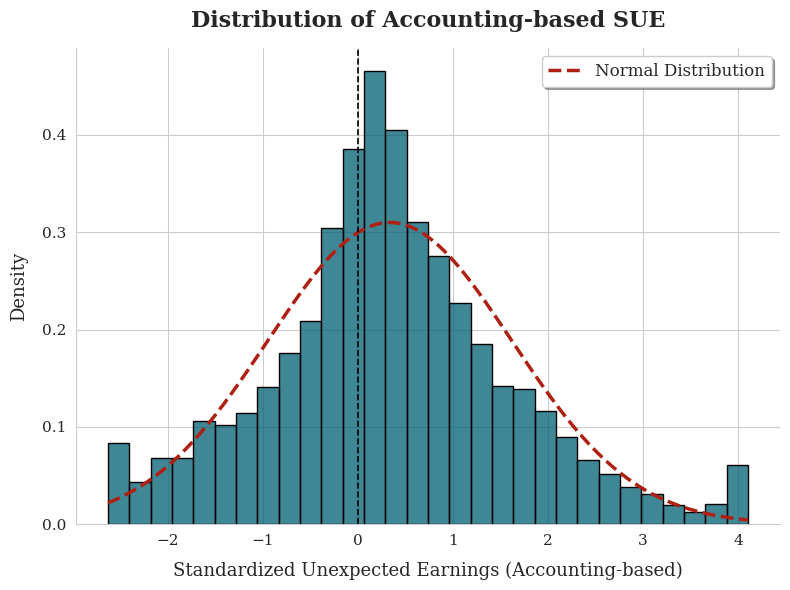

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# =====================================================================================
# HISTOGRAM WITH NORMAL OVERLAY: ACCOUNTING-BASED SUE
# =====================================================================================

# Step 1: Prepare the data
data = final_results_df['sue_eps_wins'].dropna()

# Step 2: Calculate mean and std for normal curve overlay
mu, std = data.mean(), data.std()
x = np.linspace(data.min(), data.max(), 500)
normal_pdf = norm.pdf(x, mu, std)

# Step 3: Plot Setup
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(figsize=(8, 6))

# Step 4: Plot Histogram
sns.histplot(
    data,
    bins=30,
    stat='density',
    kde=False,
    color="#005f73",
    edgecolor='black',
    ax=ax
)

# Step 5: Overlay Normal Distribution Curve
ax.plot(
    x,
    normal_pdf,
    color='#ae2012',
    linestyle='--',
    linewidth=2.5,
    label='Normal Distribution'
)

# Step 6: Annotations and Formatting
ax.set_title('Distribution of Accounting-based SUE', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Standardized Unexpected Earnings (Accounting-based)', fontsize=13, labelpad=10)
ax.set_ylabel('Density', fontsize=13, labelpad=10)

# Optional: Vertical lines for mean or zero
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2)

# Step 7: Legend and Aesthetics
ax.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
ax.tick_params(axis='both', which='major', labelsize=11)
sns.despine()

plt.tight_layout()
plt.show()


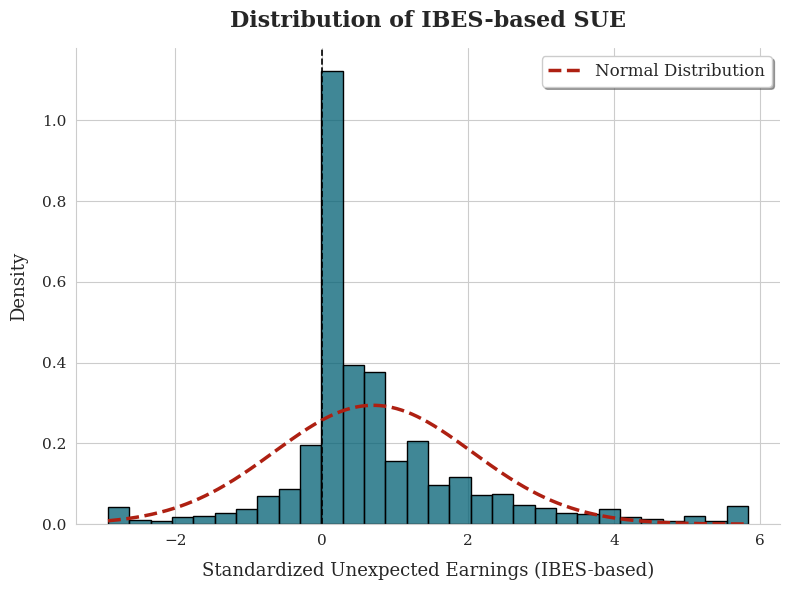

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

# =====================================================================================
# HISTOGRAM WITH NORMAL OVERLAY: IBES-BASED SUE (from final_event_df)
# =====================================================================================

# Step 1: Prepare the data (Using the correct IBES SUE column from your dataset)
data = final_event_df['sue_ibes_wins'].dropna()

# Step 2: Calculate Normal Distribution Parameters
mu, std = data.mean(), data.std()
x = np.linspace(data.min(), data.max(), 500)
normal_pdf = norm.pdf(x, mu, std)

# Step 3: Plot Settings
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

fig, ax = plt.subplots(figsize=(8, 6))

# Step 4: Histogram
sns.histplot(
    data,
    bins=30,
    stat='density',
    kde=False,
    color="#005f73",
    edgecolor='black',
    ax=ax
)

# Step 5: Normal Distribution Overlay
ax.plot(
    x,
    normal_pdf,
    color='#ae2012',
    linestyle='--',
    linewidth=2.5,
    label='Normal Distribution'
)

# Step 6: Formatting and Labels
ax.set_title('Distribution of IBES-based SUE', fontsize=16, weight='bold', pad=15)
ax.set_xlabel('Standardized Unexpected Earnings (IBES-based)', fontsize=13, labelpad=10)
ax.set_ylabel('Density', fontsize=13, labelpad=10)
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.2)

# Step 7: Legend and Grid
ax.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)
ax.tick_params(axis='both', which='major', labelsize=11)
sns.despine()

plt.tight_layout()
plt.show()


### **Cross Sectional Regression Panel Plots**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm

# =================================================================
# Exporting Individual Partial Regression Plots
# =================================================================

# --- Step 1: Helper Function and Data Preparation (No Changes) ---
def get_partial_residuals(y_var, x_var, controls_formula, df):
    df_temp = df.copy()
    df_temp['Intercept'] = 1
    y_model = sm.OLS.from_formula(f'{y_var} ~ {controls_formula}', data=df_temp, missing='drop').fit()
    y_resid = y_model.resid + y_model.params.get('Intercept', 0)
    x_model = sm.OLS.from_formula(f'{x_var} ~ {controls_formula}', data=df_temp, missing='drop').fit()
    x_resid = x_model.resid + x_model.params.get('Intercept', 0)
    return pd.DataFrame({'y_resid': y_resid, 'x_resid': x_resid})

regression_df['sue_bin'] = pd.qcut(regression_df['sue_eps_wins'], 20, labels=False, duplicates='drop')
controls_only = 'log_mve + log_bm + momentum'
controls_and_fe = 'log_mve + log_bm + momentum + C(sic) + C(YearQuarter)'

# Prepare all dataframes first
plot_data_A = regression_df.groupby('sue_bin')[['sue_eps_wins', 'CAR[2,60]_CAR_MKT']].mean()
resid_B = get_partial_residuals('Q("CAR[2,60]_CAR_MKT")', 'sue_eps_wins', controls_only, regression_df)
resid_B['sue_bin'] = pd.qcut(resid_B['x_resid'], 20, labels=False, duplicates='drop')
plot_data_B = resid_B.groupby('sue_bin')[['x_resid', 'y_resid']].mean()
resid_C = get_partial_residuals('Q("CAR[2,60]_CAR_MKT")', 'sue_eps_wins', controls_and_fe, regression_df)
resid_C['sue_bin'] = pd.qcut(resid_C['x_resid'], 20, labels=False, duplicates='drop')
plot_data_C = resid_C.groupby('sue_bin')[['x_resid', 'y_resid']].mean()
plot_data_D = regression_df.groupby('sue_bin')[['sue_eps_wins', 'CAR[2,60]_CAR_CAPM']].mean()
resid_E = get_partial_residuals('Q("CAR[2,60]_CAR_CAPM")', 'sue_eps_wins', controls_only, regression_df)
resid_E['sue_bin'] = pd.qcut(resid_E['x_resid'], 20, labels=False, duplicates='drop')
plot_data_E = resid_E.groupby('sue_bin')[['x_resid', 'y_resid']].mean()
resid_F = get_partial_residuals('Q("CAR[2,60]_CAR_CAPM")', 'sue_eps_wins', controls_and_fe, regression_df)
resid_F['sue_bin'] = pd.qcut(resid_F['x_resid'], 20, labels=False, duplicates='drop')
plot_data_F = resid_F.groupby('sue_bin')[['x_resid', 'y_resid']].mean()

# --- Step 2: Define a Consistent Plotting Function ---
def create_and_save_plot(data, x_col, y_col, title, ylabel, filename):
    """Creates a single binned scatter plot and saves it to a file."""
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(6, 5)) # Individual plot size

    sns.regplot(x=x_col, y=y_col, data=data, ax=ax,
                scatter_kws={'s': 40, 'edgecolor': 'black', 'color': '#005f73', 'alpha': 0.8},
                line_kws={'color': '#ae2012', 'linewidth': 2.5})
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('SUE (Binned)', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=12)
    sns.despine(ax=ax)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close(fig) # Close the figure to free up memory
    print(f"Saved {filename}")

# --- Step 3: Generate and Save Each of the 6 Plots ---
# Panel A Plots
create_and_save_plot(plot_data_A, 'sue_eps_wins', 'CAR[2,60]_CAR_MKT', 'Fig A: No Controls', 'Market-Adjusted CAR', 'P1.png')
create_and_save_plot(plot_data_B, 'x_resid', 'y_resid', 'Fig B: With Controls', '', 'P2.png')
create_and_save_plot(plot_data_C, 'x_resid', 'y_resid', 'Fig C: Controls + FEs', '', 'P3.png')

# Panel B Plots
create_and_save_plot(plot_data_D, 'sue_eps_wins', 'CAR[2,60]_CAR_CAPM', 'Fig D: No Controls', 'CAPM CAR', 'P4.png')
create_and_save_plot(plot_data_E, 'x_resid', 'y_resid', 'Fig E: With Controls', '', 'P5.png')
create_and_save_plot(plot_data_F, 'x_resid', 'y_resid', 'Fig F: Controls + FEs', '', 'P6.png')


c:\Users\Asus\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


Saved P1.png
Saved P2.png
Saved P3.png
Saved P4.png
Saved P5.png
Saved P6.png


### **Pre-annoucement vs Post Annoucement Drift**
---

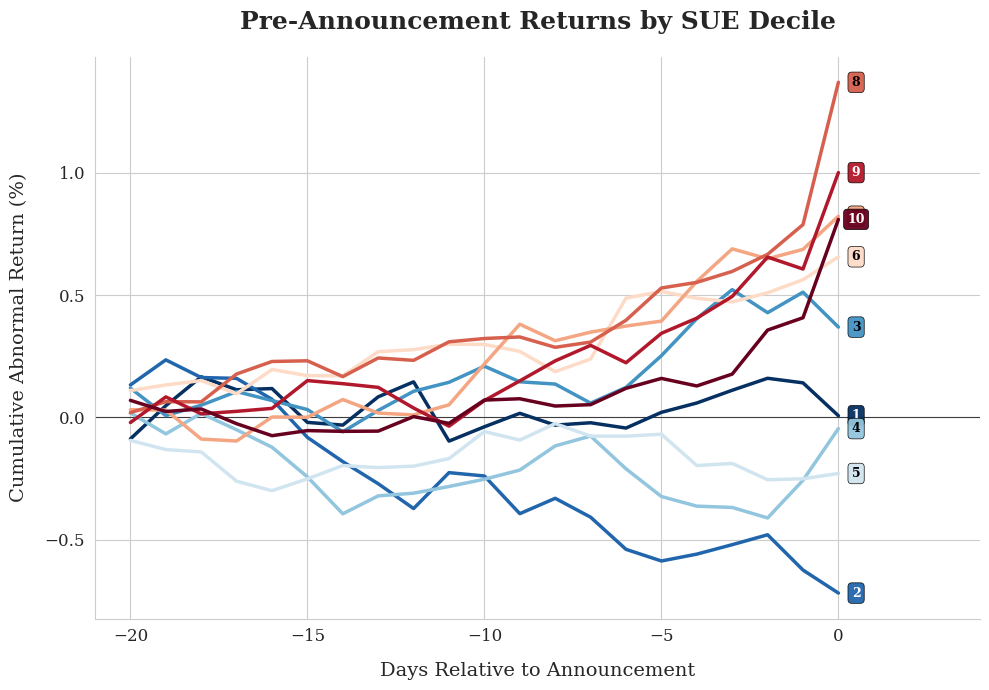

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# =================================================================
# Publication-Quality Plot: Pre-Announcement Returns by SUE Decile
# (Final Version with Enhanced Colors and Readability)
# =================================================================

# --- Step 1: Prepare the Data (No changes needed) ---
sue_info_df = final_results_df[['event_id', 'sue_eps_wins']]
plot_data = pd.merge(final_daily_ar_df, sue_info_df, on='event_id')
plot_data['sue_decile'] = pd.qcut(plot_data['sue_eps_wins'], 10, labels=False, duplicates='drop') + 1
pre_announcement_data = plot_data[plot_data['event_day'] <= 0].copy()
pre_announcement_data = pre_announcement_data.sort_values(by=['sue_decile', 'event_day'])
aar_by_decile = pre_announcement_data.groupby(['sue_decile', 'event_day'])['ar_mkt'].mean().reset_index()
aar_by_decile['caar'] = aar_by_decile.groupby('sue_decile')['ar_mkt'].cumsum()
caar_pivot = aar_by_decile.pivot(index='event_day', columns='sue_decile', values='caar') * 100

# --- Step 2: Create the Enhanced Plot ---
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(10, 7))

# --- Step 3: Define a High-Contrast, Professional Color Palette ---
# This custom palette uses rich, distinct colors and avoids light yellows.
# It transitions from cool blues (low SUE) to warm reds (high SUE).
palette = [
    '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
    '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'
]

# --- Step 4: Define a Helper Function for Optimal Text Color ---
def get_text_color(bg_color):
    """Determines if text should be black or white based on background color luminance."""
    rgb = mcolors.to_rgb(bg_color)
    # Formula for perceived luminance
    luminance = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return 'white' if luminance < 0.45 else 'black'

# --- Step 5: Plot Lines and Add Direct Labels ---
for decile in caar_pivot.columns:
    color = palette[decile-1]
    line, = ax.plot(
        caar_pivot.index,
        caar_pivot[decile],
        color=color,
        linewidth=2.5
    )

    # Add the text label at the end of the line
    last_x = caar_pivot.index[-1]
    last_y = caar_pivot[decile].iloc[-1]
    text_color = get_text_color(color)
    
    ax.text(last_x + 0.5,
            last_y,
            str(decile),
            color=text_color,
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc=color, ec='black', lw=0.5, alpha=0.95))

# --- Step 6: Finalize Formatting ---
ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.7, zorder=1)
ax.set_title('Pre-Announcement Returns by SUE Decile', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Days Relative to Announcement', fontsize=14, labelpad=12)
ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=14, labelpad=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set x-axis limits to make space for the labels
ax.set_xlim(right=caar_pivot.index[-1] + 4)

sns.despine()
plt.tight_layout()
plt.show()


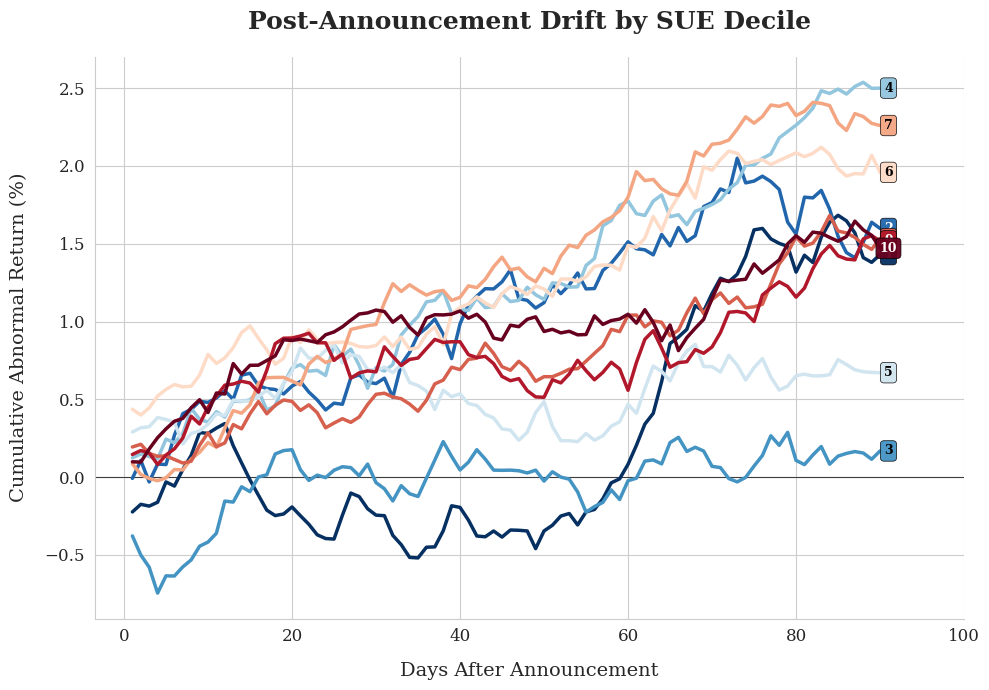

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# =================================================================
# Publication-Quality Plot: Post-Announcement Drift by SUE Decile
# (Final Version with Enhanced Colors and Readability)
# =================================================================

# --- Step 1: Prepare the Data ---
sue_info_df = final_results_df[['event_id', 'sue_eps_wins']]
plot_data = pd.merge(final_daily_ar_df, sue_info_df, on='event_id')
plot_data['sue_decile'] = pd.qcut(plot_data['sue_eps_wins'], 10, labels=False, duplicates='drop') + 1

# KEY CHANGE: Isolate only the post-announcement period (day 1 onwards)
post_announcement_data = plot_data[plot_data['event_day'] > 0].copy()

# Calculate AAR and then CAAR for the post-announcement period
aar_by_decile = post_announcement_data.groupby(['sue_decile', 'event_day'])['ar_mkt'].mean().reset_index()
aar_by_decile['caar'] = aar_by_decile.groupby('sue_decile')['ar_mkt'].cumsum()
caar_pivot = aar_by_decile.pivot(index='event_day', columns='sue_decile', values='caar') * 100

# --- Step 2: Create the Enhanced Plot ---
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(10, 7))

# --- Step 3: Define the High-Contrast, Professional Color Palette ---
palette = [
    '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
    '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'
]

# --- Step 4: Define a Helper Function for Optimal Text Color ---
def get_text_color(bg_color):
    """Determines if text should be black or white based on background color luminance."""
    rgb = mcolors.to_rgb(bg_color)
    luminance = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return 'white' if luminance < 0.45 else 'black'

# --- Step 5: Plot Lines and Add Direct Labels ---
for decile in caar_pivot.columns:
    color = palette[decile-1]
    line, = ax.plot(
        caar_pivot.index,
        caar_pivot[decile],
        color=color,
        linewidth=2.5
    )

    # Add the text label at the end of the line
    last_x = caar_pivot.index[-1]
    last_y = caar_pivot[decile].iloc[-1]
    text_color = get_text_color(color)
    
    ax.text(last_x + 1, # Small offset from the end of the line
            last_y,
            str(decile),
            color=text_color,
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc=color, ec='black', lw=0.5, alpha=0.95))

# --- Step 6: Finalize Formatting ---
ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.7, zorder=1)
ax.set_title('Post-Announcement Drift by SUE Decile', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Days After Announcement', fontsize=14, labelpad=12)
ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=14, labelpad=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set x-axis limits to make space for the labels
ax.set_xlim(right=caar_pivot.index[-1] + 10)

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# =================================================================
# EXPORTING PRE- AND POST-ANNOUNCEMENT DECILE PLOTS
# =================================================================

# --- Step 1: Common Data Preparation ---
sue_info_df = final_results_df[['event_id', 'sue_eps_wins']]
plot_data = pd.merge(final_daily_ar_df, sue_info_df, on='event_id')
plot_data['sue_decile'] = pd.qcut(plot_data['sue_eps_wins'], 10, labels=False, duplicates='drop') + 1

# --- Step 2: Define Helper Function for Text Color ---
def get_text_color(bg_color):
    rgb = mcolors.to_rgb(bg_color)
    luminance = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return 'white' if luminance < 0.45 else 'black'

# --- Step 3: Define the High-Contrast Color Palette ---
palette = [
    '#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
    '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f'
]

# --- Step 4: Generate and Save PRE-ANNOUNCEMENT Plot ---
print("Generating pre-announcement plot...")
pre_announcement_data = plot_data[plot_data['event_day'] <= 0].copy()
pre_announcement_data = pre_announcement_data.sort_values(by=['sue_decile', 'event_day'])
aar_by_decile_pre = pre_announcement_data.groupby(['sue_decile', 'event_day'])['ar_mkt'].mean().reset_index()
aar_by_decile_pre['caar'] = aar_by_decile_pre.groupby('sue_decile')['ar_mkt'].cumsum()
caar_pivot_pre = aar_by_decile_pre.pivot(index='event_day', columns='sue_decile', values='caar') * 100

fig, ax = plt.subplots(figsize=(8, 6)) # Adjusted size for side-by-side panel
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

for decile in caar_pivot_pre.columns:
    color = palette[decile-1]
    ax.plot(caar_pivot_pre.index, caar_pivot_pre[decile], color=color, linewidth=2.5)
    last_x, last_y = caar_pivot_pre.index[-1], caar_pivot_pre[decile].iloc[-1]
    text_color = get_text_color(color)
    ax.text(last_x + 0.5, last_y, str(decile), color=text_color, fontsize=8, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.2', fc=color, ec='black', lw=0.5, alpha=0.95))

ax.axhline(0, color='black', lw=0.8, alpha=0.7)
ax.set_title('Pre-Announcement Returns', fontsize=16, fontweight='bold')
ax.set_xlabel('Days Relative to Announcement', fontsize=12)
ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlim(right=caar_pivot_pre.index[-1] + 3)
sns.despine()
plt.tight_layout()
plt.savefig('pre_announcement_deciles.png', dpi=300)
plt.close(fig)
print("Saved pre_announcement_deciles.png")


# --- Step 5: Generate and Save POST-ANNOUNCEMENT Plot ---
print("\nGenerating post-announcement plot...")
post_announcement_data = plot_data[plot_data['event_day'] > 0].copy()
aar_by_decile_post = post_announcement_data.groupby(['sue_decile', 'event_day'])['ar_mkt'].mean().reset_index()
aar_by_decile_post['caar'] = aar_by_decile_post.groupby('sue_decile')['ar_mkt'].cumsum()
caar_pivot_post = aar_by_decile_post.pivot(index='event_day', columns='sue_decile', values='caar') * 100

fig, ax = plt.subplots(figsize=(8, 6)) # Adjusted size for side-by-side panel
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'

for decile in caar_pivot_post.columns:
    color = palette[decile-1]
    ax.plot(caar_pivot_post.index, caar_pivot_post[decile], color=color, linewidth=2.5)
    last_x, last_y = caar_pivot_post.index[-1], caar_pivot_post[decile].iloc[-1]
    text_color = get_text_color(color)
    ax.text(last_x + 1, last_y, str(decile), color=text_color, fontsize=8, fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.2', fc=color, ec='black', lw=0.5, alpha=0.95))

ax.axhline(0, color='black', lw=0.8, alpha=0.7)
ax.set_title('Post-Announcement Drift', fontsize=16, fontweight='bold')
ax.set_xlabel('Days After Announcement', fontsize=12)
ax.set_ylabel('') # No Y-label for the right-side plot
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlim(right=caar_pivot_post.index[-1] + 8)
sns.despine()
plt.tight_layout()
plt.savefig('post_announcement_deciles.png', dpi=300)
plt.close(fig)
print("Saved post_announcement_deciles.png")


Generating pre-announcement plot...
Saved pre_announcement_deciles.png

Generating post-announcement plot...
Saved post_announcement_deciles.png


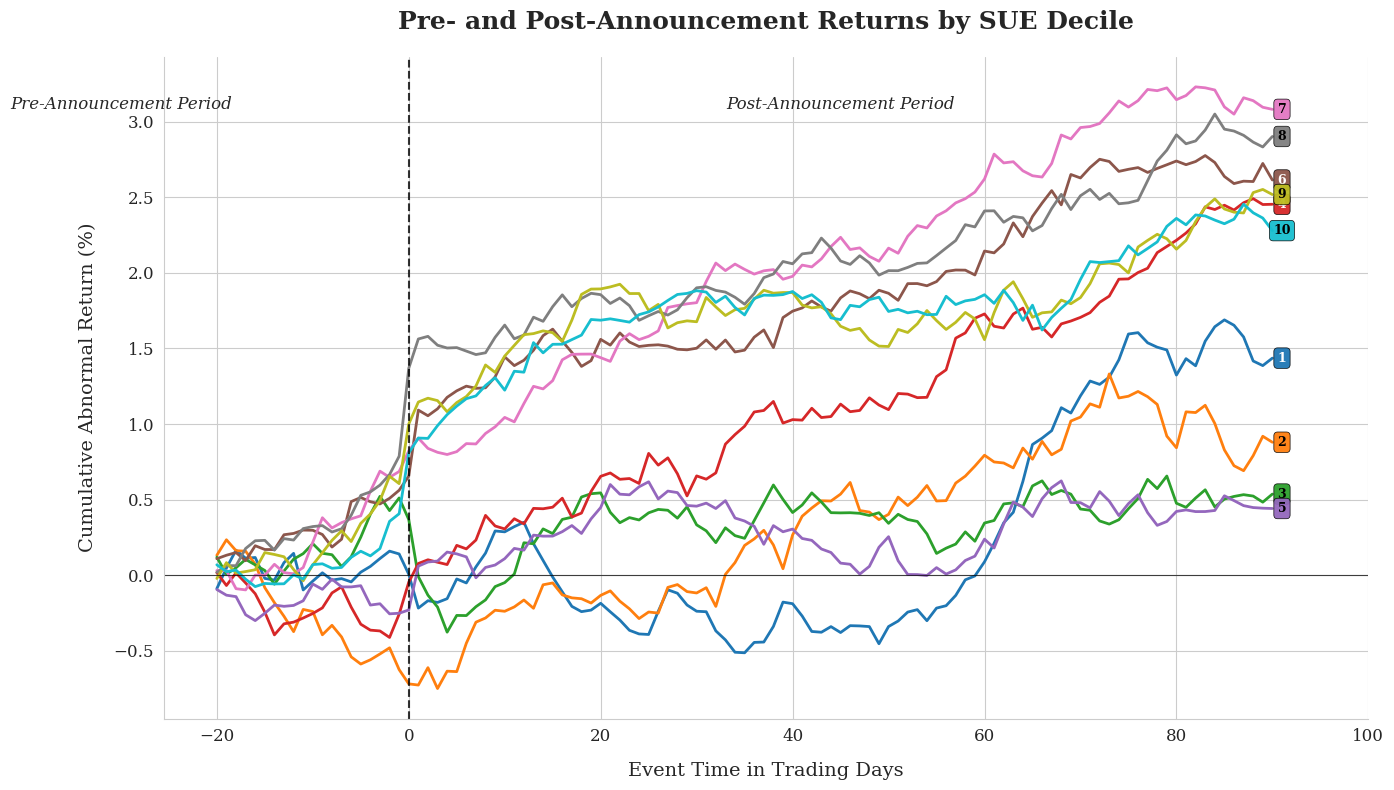

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors

# =================================================================
# Publication-Quality Plot: Combined Pre- and Post-Announcement Drift
# (Final Version with Enhanced Colors and Readability)
# =================================================================

# --- Step 1: Prepare the Data ---
sue_info_df = final_results_df[['event_id', 'sue_eps_wins']]
plot_data = pd.merge(final_daily_ar_df, sue_info_df, on='event_id')
plot_data['sue_decile'] = pd.qcut(plot_data['sue_eps_wins'], 10, labels=False, duplicates='drop') + 1

# KEY LOGIC: Use the full event window and sort correctly for a continuous cumulative sum
plot_data = plot_data.sort_values(by=['sue_decile', 'event_day'])

# Calculate the Average Abnormal Return (AAR) for each decile on each day
aar_by_decile = plot_data.groupby(['sue_decile', 'event_day'])['ar_mkt'].mean().reset_index()

# Calculate the continuous Cumulative Average Abnormal Return (CAAR) across the whole window
aar_by_decile['caar'] = aar_by_decile.groupby('sue_decile')['ar_mkt'].cumsum()
caar_pivot = aar_by_decile.pivot(index='event_day', columns='sue_decile', values='caar') * 100

# --- Step 2: Create the Enhanced Plot ---
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'serif'
fig, ax = plt.subplots(figsize=(14, 8))

# --- Step 3: Define a High-Contrast, Professional Color Palette ---
# This 'tab10' palette is designed for maximum categorical distinction.
palette = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
]

# --- Step 4: Define a Helper Function for Optimal Text Color ---
def get_text_color(bg_color):
    """Determines if text should be black or white based on background color luminance."""
    rgb = mcolors.to_rgb(bg_color)
    luminance = 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]
    return 'white' if luminance < 0.4 else 'black'

# --- Step 5: Plot Lines and Add Direct Labels ---
for decile in caar_pivot.columns:
    color = palette[decile-1]
    line, = ax.plot(caar_pivot.index, caar_pivot[decile], color=color, linewidth=2.0)

    # Add the text label at the end of the line
    last_x = caar_pivot.index[-1]
    last_y = caar_pivot[decile].iloc[-1]
    text_color = get_text_color(color)
    
    ax.text(last_x + 1, last_y, str(decile), color=text_color, fontsize=9,
            fontweight='bold', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc=color, ec='black', lw=0.5, alpha=0.95))

# --- Step 6: Finalize Formatting and Annotations ---
# Add a vertical line at day 0 to separate the periods
ax.axvline(0, color='black', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

# Add text annotations for the periods
ax.text(-30, ax.get_ylim()[1] * 0.9, 'Pre-Announcement Period', ha='center', fontsize=12, style='italic')
ax.text(45, ax.get_ylim()[1] * 0.9, 'Post-Announcement Period', ha='center', fontsize=12, style='italic')

# Set titles and labels
ax.set_title('Pre- and Post-Announcement Returns by SUE Decile', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Event Time in Trading Days', fontsize=14, labelpad=12)
ax.set_ylabel('Cumulative Abnormal Return (%)', fontsize=14, labelpad=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# Set x-axis limits to make space for the labels
ax.set_xlim(ax.get_xlim()[0], caar_pivot.index[-1] + 10)

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# =================================================================
# EXPORTING FINAL PRE- AND POST-ANNOUNCEMENT DECILE PLOTS
# (Standardized Axes, Direct Labeling, and Enhanced Visibility)
# =================================================================

# --- Step 1: Common Data Preparation ---
sue_info_df = final_results_df[['event_id', 'sue_eps_wins']]
plot_data = pd.merge(final_daily_ar_df, sue_info_df, on='event_id')
plot_data['sue_decile'] = pd.qcut(plot_data['sue_eps_wins'], 10, labels=False, duplicates='drop') + 1

# --- Step 2: Calculate CAARs for Both Periods ---
# Pre-announcement
pre_ann_data = plot_data[plot_data['event_day'] <= 0].copy().sort_values(by=['sue_decile', 'event_day'])
aar_pre = pre_ann_data.groupby(['sue_decile', 'event_day'])['ar_mkt'].mean().reset_index()
aar_pre['caar'] = aar_pre.groupby('sue_decile')['ar_mkt'].cumsum()
caar_pivot_pre = aar_pre.pivot(index='event_day', columns='sue_decile', values='caar') * 100

# Post-announcement
post_ann_data = plot_data[plot_data['event_day'] > 0].copy()
aar_post = post_ann_data.groupby(['sue_decile', 'event_day'])['ar_mkt'].mean().reset_index()
aar_post['caar'] = aar_post.groupby('sue_decile')['ar_mkt'].cumsum()
caar_pivot_post = aar_post.pivot(index='event_day', columns='sue_decile', values='caar') * 100

# --- Step 3: Determine Standardized Y-Axis Limits ---
global_min = min(caar_pivot_pre.min().min(), caar_pivot_post.min().min())
global_max = max(caar_pivot_pre.max().max(), caar_pivot_post.max().max())
y_axis_buffer = (global_max - global_min) * 0.1 # Add 10% buffer
standard_ylim = (global_min - y_axis_buffer, global_max + y_axis_buffer)


# --- Step 4: Define a Consistent, High-Quality Plotting Function ---
def create_and_save_plot(caar_pivot, title, xlabel, ylabel, filename, ylim, x_offset):
    """Creates a single, styled decile plot with direct labels and saves it."""
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(8, 6))

    for decile in caar_pivot.columns:
        if decile == 10:
            color, lw, z = '#005f73', 3.0, 3
        elif decile == 1:
            color, lw, z = '#ae2012', 3.0, 3
        else:
            color, lw, z = '#888888', 1.8, 2
        
        ax.plot(caar_pivot.index, caar_pivot[decile], color=color, linewidth=lw, zorder=z, alpha=0.9)
        
        # Add direct label at the end of each line
        last_x = caar_pivot.index[-1]
        last_y = caar_pivot[decile].iloc[-1]
        ax.text(last_x + x_offset, last_y, str(decile), color=color, fontsize=10, fontweight='bold', ha='center', va='center')


    ax.axhline(0, color='black', lw=0.8, alpha=0.7)
    ax.set_title(title, fontsize=16, fontweight='bold')
    
    # IMPROVEMENT: Bolden axis labels
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Apply standardized Y-axis limits
    ax.set_ylim(ylim)
    
    # Adjust x-axis to make room for labels
    ax.set_xlim(right=caar_pivot.index[-1] + (x_offset * 4))
    
    sns.despine()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close(fig)
    print(f"Saved {filename}")

# --- Step 5: Generate and Save Both Plots ---
create_and_save_plot(caar_pivot_pre, 'Pre-Announcement Returns', 'Days Relative to Announcement', 'Cumulative Abnormal Return (%)', 'pre_announcement_final.png', standard_ylim, 0.5)
create_and_save_plot(caar_pivot_post, 'Post-Announcement Drift', 'Days After Announcement', '', 'post_announcement_final.png', standard_ylim, 1.5)


Saved pre_announcement_final.png
Saved post_announcement_final.png
